This ipython notebook details the steps taken in the *in vitro* pipeline that are described in Supplementary Methods. This notebook relies on input files and library code being in the appropriate relative location to this notebook.

Some cells are labeled `QC Cells` and some `Pipeline Cells`. The `QC Cells` illustrate the QC process and do not need to be run for the pipeline to work.

Note that the data exploration/QC steps that are shown in the code are illustrative rather than exhaustive. They demonstrate some of the pieces of Extended Data Figure 2 that we used for filtration. The specific samples that are listed for elimination are exactly those we eliminated in the final data sets available in Supplemental Table 7. 

### Pipeline Cells

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

from in_vitro_library_code.util import (superset, istd_tic_transform, media_based_transform,
                                        join_across_modes, combine_features_in_fc_data,
                                        add_multipeaks, name_detection_id, intra_replicate_correlation)
from in_vitro_library_code.exp_design import (BiologicalSampleGroup, Experiment,
                                              rebuild_bsg_without_samples, get_bsg_with_samples,
                                              partition_samples, squeeze_metadata)

In [2]:
###
# Step 1: load data, eliminate a subset of features
###
# This cell requires the bacterial supernatant data (all 3 modes), the feature removal list
# and the sample metadata.

master_sample_database_fp = 'supplemental_table_5.xlsx'
md = pd.read_excel(io=master_sample_database_fp, index_col=0, sheet_name='mf')
# Force storage_loc_plate to str type - pandas doesn't detect this.
md['storage_loc_plate'] = md['storage_loc_plate'].astype(str)

c18pos_msdata_fp = 'bacterial_supernatant_data/c18positive_data.txt'
c18neg_msdata_fp = 'bacterial_supernatant_data/c18negative_data.txt'
hilicpos_msdata_fp = 'bacterial_supernatant_data/hilicpositive_data.txt'

# Remove the non-biological features. These are contaminants from plastic and glassware
# or misidentifications.
nonbio_features_fp = 'bacterial_supernatant_data/qc/in_vitro_nonbio_features.xlsx'
nb_f = pd.read_excel(nonbio_features_fp, index_col=None)

c18pos_msdata = pd.read_csv(c18pos_msdata_fp, sep='\t', index_col=0)
c18neg_msdata = pd.read_csv(c18neg_msdata_fp, sep='\t', index_col=0)
hilicpos_msdata = pd.read_csv(hilicpos_msdata_fp, sep='\t', index_col=0)

_c18p_to_remove = nb_f.loc[pd.notnull(nb_f['c18positive']),
                           'c18positive'].values
_c18n_to_remove = nb_f.loc[pd.notnull(nb_f['c18negative']),
                           'c18negative'].values
_hp_to_remove = nb_f.loc[pd.notnull(nb_f['hilicpositive']),
                         'hilicpositive'].values

c18pos_msdata = c18pos_msdata.loc[:, ~np.in1d(c18pos_msdata.columns,
                                              _c18p_to_remove)]
c18neg_msdata = c18neg_msdata.loc[:, ~np.in1d(c18neg_msdata.columns,
                                              _c18n_to_remove)]
hilicpos_msdata = hilicpos_msdata.loc[:, ~np.in1d(hilicpos_msdata.columns,
                                                  _hp_to_remove)]

# Concatenate data and prepare for next steps.
msdata = (c18pos_msdata, c18neg_msdata, hilicpos_msdata)

samples_with_msdata = set(np.concatenate((c18pos_msdata.index,
                                          c18neg_msdata.index,
                                          hilicpos_msdata.index)))

md = md.loc[np.in1d(md.index, list(samples_with_msdata)), :].copy()

Below we'll do some QC on the samples to produce a set of samples that should be removed. These samples are low quality, probably the product of technical process (piepetting error, incomplete protein crash, LC pump pressure fluctuation, ion source behavior, etc.). This code is illustrative rather than an exhaustive list of the varaibles and clustering we looked at.

In [3]:
###
# Step 2: QC on samples, elimination of bad samples.
###

# 1. We're grouping by the following categories to build bsg's.
bio_gb = ['experiment', 'run_designation', 'sample_type', 'media',
          'culture_source']

bsgs = []
samples_for_inspection = []
for mode_msdata in msdata:
    # Subset metadata - require totally clean cultures and being in mode_msdata
    # but allow media blanks through as well. Exclude no injection blanks.
    idxs = (md['sample_type'] == 'supernatant') & (md['clean_by_16s'] == 'y')
    idxs = idxs | (md['sample_type'] == 'media_blank')
    idxs = idxs | (md['sample_type'] == 'qc')
    idxs = idxs & np.in1d(md.index, mode_msdata.index)

    ss_md = md[idxs]

    mode_bsgs = {}
    mode_samples_for_inspection = []

    for key, samples in ss_md.groupby(bio_gb).groups.items():
        try:
            bsg = BiologicalSampleGroup(ss_md.loc[samples])
            mode_bsgs[frozenset(samples)] = bsg
        except ValueError as e:
            print(e)
            print()
            mode_samples_for_inspection.append(samples.values)
    bsgs.append(mode_bsgs)
    samples_for_inspection.append(mode_samples_for_inspection)

# Make sure there are no samples that we detected inappropriate metadata for.
assert all(len(i) == 0 for i in samples_for_inspection)

### QC Cells
Calculate correlation coefficients (intra-replicate) and plot them to understand per-experiment variation.

In [4]:
modes = ('c18positive', 'c18negative', 'hilicpositive')

log_msdata = [np.log2(1+mode_msdata) for mode_msdata in msdata]

sample_groups, pearson_ccs, pearson_ccs_log = [], [], []

for mode_bsgs, mode_msdata, log_mode_msdata in zip(bsgs, msdata, log_msdata):
    tmp_sgs, tmp_pcc, tmp_pccl = [], [], []
    for samples, bsg in mode_bsgs.items():
        if ((bsg.sample_type == 'supernatant') or
            (bsg.sample_type == 'media_blank')) and len(samples) > 1:
            tmp_pcc.append(intra_replicate_correlation(mode_msdata, samples,
                                                       False))
            tmp_pccl.append(intra_replicate_correlation(log_mode_msdata,
                                                        samples, False))
            tmp_sgs.append(samples)
    sample_groups.append(tmp_sgs)
    pearson_ccs.append(tmp_pcc)
    pearson_ccs_log.append(tmp_pccl)
nd = []
for mode, samples, pcc, pccl in zip(modes, sample_groups, pearson_ccs,
                                    pearson_ccs_log):
    for exp_samples, exp_pccs, exp_pccls in zip(samples, pcc, pccl):
        for i, j, k in zip(exp_samples, exp_pccs, exp_pccls):
            nd.append([i, j, k, mode])
ndf = pd.DataFrame(nd, columns=['sample', 'pcc', 'pccl', 'mode']).set_index('sample')
ndf['experiment'] = ['exp_' + str(i) for i in md.loc[ndf.index, 'experiment']]
# WARNING: the format of this dataframe is misleading. Each row has a sample
# identifier and then a set of correlation coefficients for that sample. Since
# the correlation coefficient must reference another sample, this appears 
# inaccurate. However, for what we are doing, all we need to ensure is that there
# isn't double counting (e.g. the dataframe doesn't have rho(a, b) and rho(b,a)).

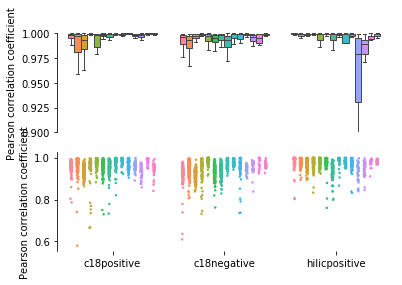

In [5]:
# Visualize
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(211) 
sns.boxplot(data=ndf, x='mode', y='pcc', hue='experiment', saturation=1.0,
            dodge=True, linewidth=1.0, fliersize=0)
# Clean up plot
ax.set_ylim(0.9, 1.0)
for spine in ['bottom', 'top', 'right']:
    ax.spines[spine].set_visible(False)
ax.set_xticks([])
ax.set_xlabel('')
ax.set_ylabel('Pearson correlation coefficient')
# handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()

ax = fig.add_subplot(212) 
sns.stripplot(data=ndf, x='mode', y='pccl', hue='experiment', dodge=True,
              jitter=True, ax=ax, size=2.5)
# Clean up plot
for spine in ['bottom', 'top', 'right']:
    ax.spines[spine].set_visible(False)
ax.set_xticklabels(modes)
ax.set_xlabel('')
ax.set_ylabel('Pearson correlation coefficient')
# handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()

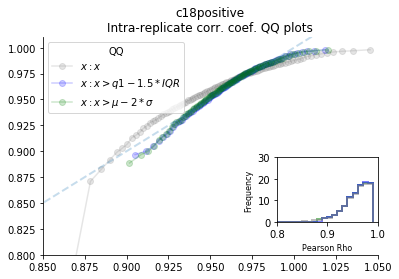

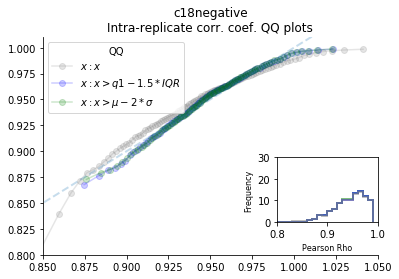

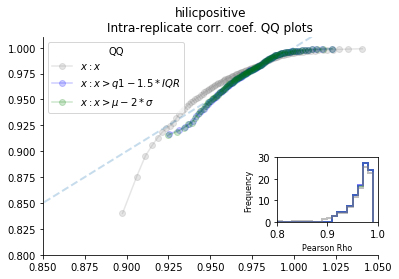

In [6]:
# Let's identify the threshold for sample removals.
from scipy.stats.distributions import norm

# Used for centile calculations below
def iqr_outlier(data):
    q1, q3 = np.percentile(data, [25, 75])
    return q1 - 1.5 * (q3 - q1)
_centiles = np.linspace(.01, 0.99, 99)
_percentile_bins = np.linspace(1, 99, 99)

modes = ('c18positive', 'c18negative', 'hilicpositive')
for mode in modes:
    data = ndf.loc[(ndf['mode'] == mode), 'pccl'].values

    # Identify how many samples would be removed with different thresholds.
    # Compare the 1.5*IQR to a threshold of mu - 2*sigma.
    iqr_threshold = iqr_outlier(data)
    mu, sigma = data.mean(), data.std()
    sigma_thresh  = mu - 2 * sigma
    
    # print(mode)
    # print(data.shape, iqr_threshold, mu, sigma, sigma_thresh)
    # print('iqr: %s / %s' % ((data < iqr_threshold).sum(), data.shape[0]))
    # print('mu: %s / %s' % ((data < sigma_thresh).sum(), data.shape[0]))
    # print()


    data_centiles = np.percentile(data, _percentile_bins)
    norm_centiles = norm.ppf(_centiles, loc=mu, scale=sigma)

    d1 = data[data > iqr_threshold]
    d1mu, d1sigma = d1.mean(), d1.std()
    iqr_based_data_centiles = np.percentile(d1, _percentile_bins)
    iqr_based_norm_centiles = norm.ppf(_centiles, loc=d1mu, scale=d1sigma)
    
    d2 = data[data > sigma_thresh]
    d2mu, d2sigma = d2.mean(), d2.std()
    std_based_data_centiles = np.percentile(d2, _percentile_bins)
    std_based_norm_centiles = norm.ppf(_centiles, loc=d2mu, scale=d2sigma)
    

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

    ax.plot(norm_centiles, data_centiles, 'o-', color='gray', alpha=0.2,
            label=r'$x: x$')    
    ax.plot(iqr_based_norm_centiles, iqr_based_data_centiles, 'o-', 
            color='blue', label=r'$x: x > q1 - 1.5 * IQR$', alpha=0.2)
    ax.plot(std_based_norm_centiles, std_based_data_centiles, 'o-', 
            color='green', label=r'$x: x > \mu - 2*\sigma$', alpha=0.2)

    # Clean up axes.
    ax.plot([0.5, 1.1], [0.5, 1.1], '--', lw=2, alpha=0.25)
    ax.set_xlim(0.85, 1.05)
    ax.set_ylim(0.8, 1.01)
    #ax.set_xlabel('Normal quantiles')
    #ax.set_ylabel('Observed quantiles')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('%s\nIntra-replicate corr. coef. QQ plots' % mode)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.legend(loc=2, title='QQ', fontsize=10)

    # Now create inset axes for the histograms
    # https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/zoom_inset_axes.html#sphx-glr-gallery-subplots-axes-and-figures-zoom-inset-axes-py
    inset_ax = ax.inset_axes([0.7, 0.15, 0.3, 0.3])
    inset_ax.hist([data, d1, d2], lw=2, alpha=0.5, bins=_centiles, 
                  histtype='step', density=True, color=['gray', 'blue', 'green'])
    inset_ax.set_xlim(0.8, 1.0)
    inset_ax.set_ylim(0, 30)
    inset_ax.set_xlabel('Pearson Rho', fontsize=8)
    inset_ax.set_ylabel('Frequency', fontsize=8)

### Pipeline Cells

In [7]:
## Step 2.1
# 2. We're removing samples that are not well correlated with their replicates.
# Check intra-replicate correlations - see the correlations plots.
# We remove samples with a correlation coefficient below. Note that for one bsg
# we are removing two samples; it only has two, so it's totally removed.
c18pos_lowcc_samples = [['s00028'],
                        ['s00030'],
                        ['s00035'],
                        ['s00454'],
                        ['s00913'],
                        ['s00989'],
                        ['s01559', 's01560'],
                        ['s01792'],
                        ['s01802'],
                        ['s01805'],
                        ['s01844'],
                        ['s02676'],
                        ['s02761'],
                        ['s05216'],
                        ['s05326']]

c18neg_lowcc_samples = [['s00330'],
                        ['s00811'],
                        ['s01456'],
                        ['s01529'],
                        ['s01530'],
                        ['s01914'],
                        ['s01927'],
                        ['s01962.3'],
                        ['s02459'],
                        ['s02480'],
                        ['s03149', 's03150', 's03151'],
                        ['s03159'],
                        ['s03675'],
                        ['s03709','s03713', 's03715', 's03717'],
                        ['s03735'],
                        ['s05305']]

hilicpos_lowcc_samples = [['s00560'],
                          ['s00577'],
                          ['s00669'],
                          ['s01150'],
                          ['s01151'],
                          ['s01157', 's01158', 's01159'],
                          ['s01180.2'],
                          ['s01209'],
                          ['s02035'],
                          ['s02282'],
                          ['s02388'],
                          ['s02912'],
                          ['s03591'],
                          ['s04729'],
                          ['s04734'],
                          ['s04739'],
                          ['s05211'],
                          ['s05435']]

low_cc_samples = (c18pos_lowcc_samples, c18neg_lowcc_samples,
                  hilicpos_lowcc_samples)

for idx in range(3):
    for low_cc_sample_group in low_cc_samples[idx]:
        old_bsg_key, old_bsg = get_bsg_with_samples(bsgs[idx],
                                                    low_cc_sample_group)
        new_bsg_key, new_bsg = rebuild_bsg_without_samples(old_bsg,
                                                           low_cc_sample_group)
        del bsgs[idx][old_bsg_key]
        if new_bsg_key is not None:
            bsgs[idx][new_bsg_key] = new_bsg
        else: # all samples for the bsg were removed.
            pass

## Step 2.2
# We are building Experiment objects to group each set of `mode_bsgs`.
# First, we'll treat each mass spec run as an experiment, regardless of the
# culturing experiment it came from.
# The samples we need are all the QC's, no injection blanks, media blanks and
# supernatants that passed the `bsgs` creation stage. Note that the no
# injection blanks weren't originally included in the `bsgs` creation.
good_samples = []
for mode_bsgs in bsgs:
    for samples in mode_bsgs.keys():
        good_samples.extend(list(samples))
# Check no sample inadvertently included twice.
assert len(good_samples) == len(set(good_samples))

idxs = np.in1d(md.index, good_samples)
idxs = idxs | (md['sample_type'] == 'ni_blank')

ss_md = md[idxs]

exp_groups = []
exp_samples = []
exp_groupby = ['experiment', 'run_designation']

for md_key, samples in ss_md.groupby(exp_groupby).groups.items():
    exp_groups.append(md_key)
    exp_samples.append(samples.values)

combined_bsgs = dict()
for bsg in bsgs:
    combined_bsgs.update(bsg)
assert len(combined_bsgs) == sum([len(i) for i in bsgs])

exps = {}
for eg, es in zip(exp_groups, exp_samples):
    tmp = partition_samples(es, combined_bsgs, ss_md)
    exp = Experiment(culture_sample_groups=tmp[0],
                     unspent_medias=tmp[1],
                     media_in_samples=tmp[2],
                     cultured_in=tmp[3],
                     ni_blank_samples=tmp[4],
                     qc_samples=tmp[5],
                     md=ss_md)
    exps[eg] = exp

###
# Step 2.3 data cleaning steps.
# Check inter-replicate correlations - see the correlations plots.
# Check who doesn't have media.
###

exps_wo_media = []
for k, exp in exps.items():
    if not exp.has_needed_unspent_media:
        exps_wo_media.append(k)
for k in exps_wo_media:
    need = set(exps[k].cultured_in.keys())
    have = set(exps[k].unspent_medias.keys())
    print(k, need - have)

# Let's add media blanks based on same run/temporal proximity.
# format [(exp missing media, media it's missing, exp with that media),...]
media_to_add = [((20180512, 'c18_pos_2'), 'mm', (20180512, 'c18_pos_1')),
                ((20180618, 'c18_pos_1'), 'mm', (20180618, 'c18_pos_2')),
                ((20180512, 'c18_neg_2'), 'mm', (20180512, 'c18_neg_1')),
                ((20180512, 'hilic_pos_2'), 'mm', (20180512, 'hilic_pos_1')),
                ((20180512, 'hilic_pos_3'), 'mm', (20180512, 'hilic_pos_1')),
                ((20190228, 'hilic_pos_1'), 'ycfag', (20180728, 'hilic_pos_1'))]

for exp_needs, media, exp_has in media_to_add:
    tmp = exps[exp_has]
    to_add = {media: tmp.unspent_medias[media]}
    exps[exp_needs].add_unspent_media_samples(to_add)

(20190228.0, 'hilic_pos_1') {'ycfag'}
(20180512.0, 'hilic_pos_3') {'mm'}
(20180618.0, 'c18_pos_1') {'mm'}
(20180512.0, 'c18_pos_2') {'mm'}
(20180512.0, 'c18_neg_2') {'mm'}
(20180512.0, 'hilic_pos_2') {'mm'}


Now we do the media and ISTD based corrections. We'll examine samples with PCA afterwards to isolate some poorly performing ones to eliminate. 

In [11]:
###
# Step 3: build delta, fc, istd corrected, etc matrices
# 1. istd tic correction
# 2. fc, delta, raw
###

# Build the `sample_map` that relates each sample to the normalization blank.
# See the documentation in `media_based_transform` for more description.

# For supernatant samples, we'll need the media blank to normalize to. We'll 
# also use the mean of each media blank to normalize each media blank sample.
# For QCs and no injection blanks, we'll normalize to the average of every
# other sample in the experiment.
sample_map = defaultdict(dict)
for k, exp in exps.items():
    mode = exp.chromatography + exp.ionization
    # First, add supernatants to be normalized.
    for media, sups in exp.cultured_in.items():
        # All samples grown in a given media should be normalized by that
        # media.
        sample_map[mode][frozenset(superset(sups))] = exp.unspent_medias[media]
        # Normalize each media by the mean of itself.
        sample_map[mode][frozenset(exp.unspent_medias[media])] = \
            exp.unspent_medias[media]
    # Add any media blanks which were missed. This can happen if a media blank
    # was run, but the supernatants it was blanking have been discarded.
    for media, media_samples in exp.unspent_medias.items():
        if frozenset(media_samples) not in sample_map[mode]:
            sample_map[mode][frozenset(media_samples)] = \
                frozenset(media_samples)
    # Second, add ni blanks and qcs. Normalize ni blanks and qc samples by
    # every sample in the experiment (other than ni blanks and qcs).
    tmp = exp.samples['supernatants'].union(exp.samples['unspent_medias'])
    sample_map[mode][frozenset(exp.samples['ni_blanks'])] = tmp
    sample_map[mode][frozenset(exp.samples['qcs'])] = tmp

samples = (superset(sample_map['c18positive'].keys()).union(
           superset(sample_map['c18positive'].values())),
           superset(sample_map['c18negative'].keys()).union(
           superset(sample_map['c18negative'].values())),
           superset(sample_map['hilicpositive'].keys()).union(
           superset(sample_map['hilicpositive'].values())))

# istds_for_correction = [('IS_Cl-phenylalanine', 'IS_Br-phenylalanine',
#                          'IS_d5-phenylalanine_peak2', 'IS_d5-tryptophan',
#                          'IS_d3-methionine', 'IS_d3-leucine',
#                          'IS_2-flurophenylglycine', 'IS_d9-carnitine'),
#                         ('IS_Cl-phenylalanine', 'IS_Br-phenylalanine',
#                          'IS_d5-tryptophan',
#                          'IS_d5-hippuric acid (N-d5-Benzoylglycine)',
#                          'IS_d15-octanoic acid', 'IS_d19-decanoic acid',
#                          'IS_tridecanoic acid'),
#                         ('IS_Cl-phenylalanine', 'IS_Br-phenylalanine')]

# Now we need to carry out two different normalizations.
# 1. We'll normalize some data by the sum of internal standards.
# 2. We'll combine certain multipeaks into one peak for one type of data.
istds_for_correction = [('m_c18p_0563', 'm_c18p_0564', 'm_c18p_0560',
                         'm_c18p_0557', 'm_c18p_0565', 'm_c18p_0556',
                         'm_c18p_0562'),
                        ('m_c18n_0564', 'm_c18n_0563', 'm_c18n_0558',
                          'm_c18n_0559', 'm_c18n_0560', 'm_c18n_0561'),
                        ('m_hilicp_0362', 'm_hilicp_0363')]

uncombined_peaks_dname = {'c18positive':[['m_c18p_0233', 'm_c18p_0234'],
                                         ['m_c18p_0080', 'm_c18p_0081']],
                          'c18negative':[['m_c18n_0108', 'm_c18n_0107'],
                                         ['m_c18n_0016', 'm_c18n_0039'],
                                         ['m_c18n_0139', 'm_c18n_0140'],
                                         ['m_c18n_0168', 'm_c18n_0166'],
                                         ['m_c18n_0237' ,'m_c18n_0238']],
                          'hilicpositive':[['m_hilicp_0084', 'm_hilicp_0085'],
                                           ['m_hilicp_0236', 'm_hilicp_0235'],
                                           ['m_hilicp_0124', 'm_hilicp_0123'],
                                           ['m_hilicp_0238', 'm_hilicp_0237']]}

# Could be combined but not found in data
# ('m_c18p_0006', 'm_c18p_0185')

modes = ('c18positive', 'c18negative', 'hilicpositive')

(fc_data, delta_data, tic_corr_data) = [], [], []
(fc_peak_combined_data, delta_peak_combined_data, 
 tic_corr_peak_combined_data) = [], [], []

for mode, mode_msdata, mode_istds in zip(modes, msdata, istds_for_correction):
    # Make ISTD correction on all data.
    tic_corrected = istd_tic_transform(mode_msdata, mode_istds, by='median')

    # Retain media blanks and supernatant samples only for the fc and delta
    # data.
    samples_to_keep = superset(sample_map[mode].keys()).union(
                      superset(sample_map[mode].values()))
    idxs = mode_msdata.index[np.in1d(mode_msdata.index, list(samples_to_keep))]

    # Make transformations.
    # For the FC based on media blank, we need to add 1 to ensure that any
    # media values that are 0 don't cause inf's. This alters the data to a
    # meaningless degree.
    mode_fc = media_based_transform(1. + tic_corrected.loc[idxs],
                                    sample_map[mode],
                                    fc_or_delta='fc',
                                    data_is_log_transformed=False)

    mode_delta = media_based_transform(tic_corrected.loc[idxs],
                                       sample_map[mode],
                                       fc_or_delta='delta',
                                       data_is_log_transformed=False)

    # Make peak combined data. This data combines mulipeaked features in
    # each mode.
    ptc = uncombined_peaks_dname[mode]
    ptc_new_names = [i[0] for i in ptc]
    # Since this is fold-change data, we must add 1 to prevent division by 0.
    # Same logic as mode_fc data.
    pc_mode_data = add_multipeaks(tic_corrected.loc[idxs], ptc, ptc_new_names)



    pc_mode_fc = media_based_transform(1 + pc_mode_data,
                                       sample_map[mode],
                                       fc_or_delta='fc',
                                       data_is_log_transformed=False)

    pc_mode_delta = media_based_transform(1 + pc_mode_data,
                                          sample_map[mode],
                                          fc_or_delta='delta',
                                          data_is_log_transformed=False)

    # Note that the indices of mode_fc and mode_delta are identical, but the
    # log2_tic_corrected data contains blanks and thus has a superset
    # of those indicies.
    assert (mode_fc.index == mode_delta.index).all()
    assert (mode_fc.columns == mode_delta.columns).all()
    assert (pc_mode_data.index == pc_mode_fc.index).all()
    assert (pc_mode_data.columns == pc_mode_fc.columns).all()

    fc_data.append(mode_fc)
    delta_data.append(mode_delta)
    tic_corr_data.append(tic_corrected)
    
    fc_peak_combined_data.append(pc_mode_fc)
    delta_peak_combined_data.append(pc_mode_delta)
    tic_corr_peak_combined_data.append(pc_mode_data)

### QC Cells
Selecting the performant internal standards is essential. Here we are visualizing the internal standards for the mega medium data; we've done the normalization above based on the data we are visualizing in this cell.

/Users/wdwvt/anaconda/envs/py3/lib/python3.5/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


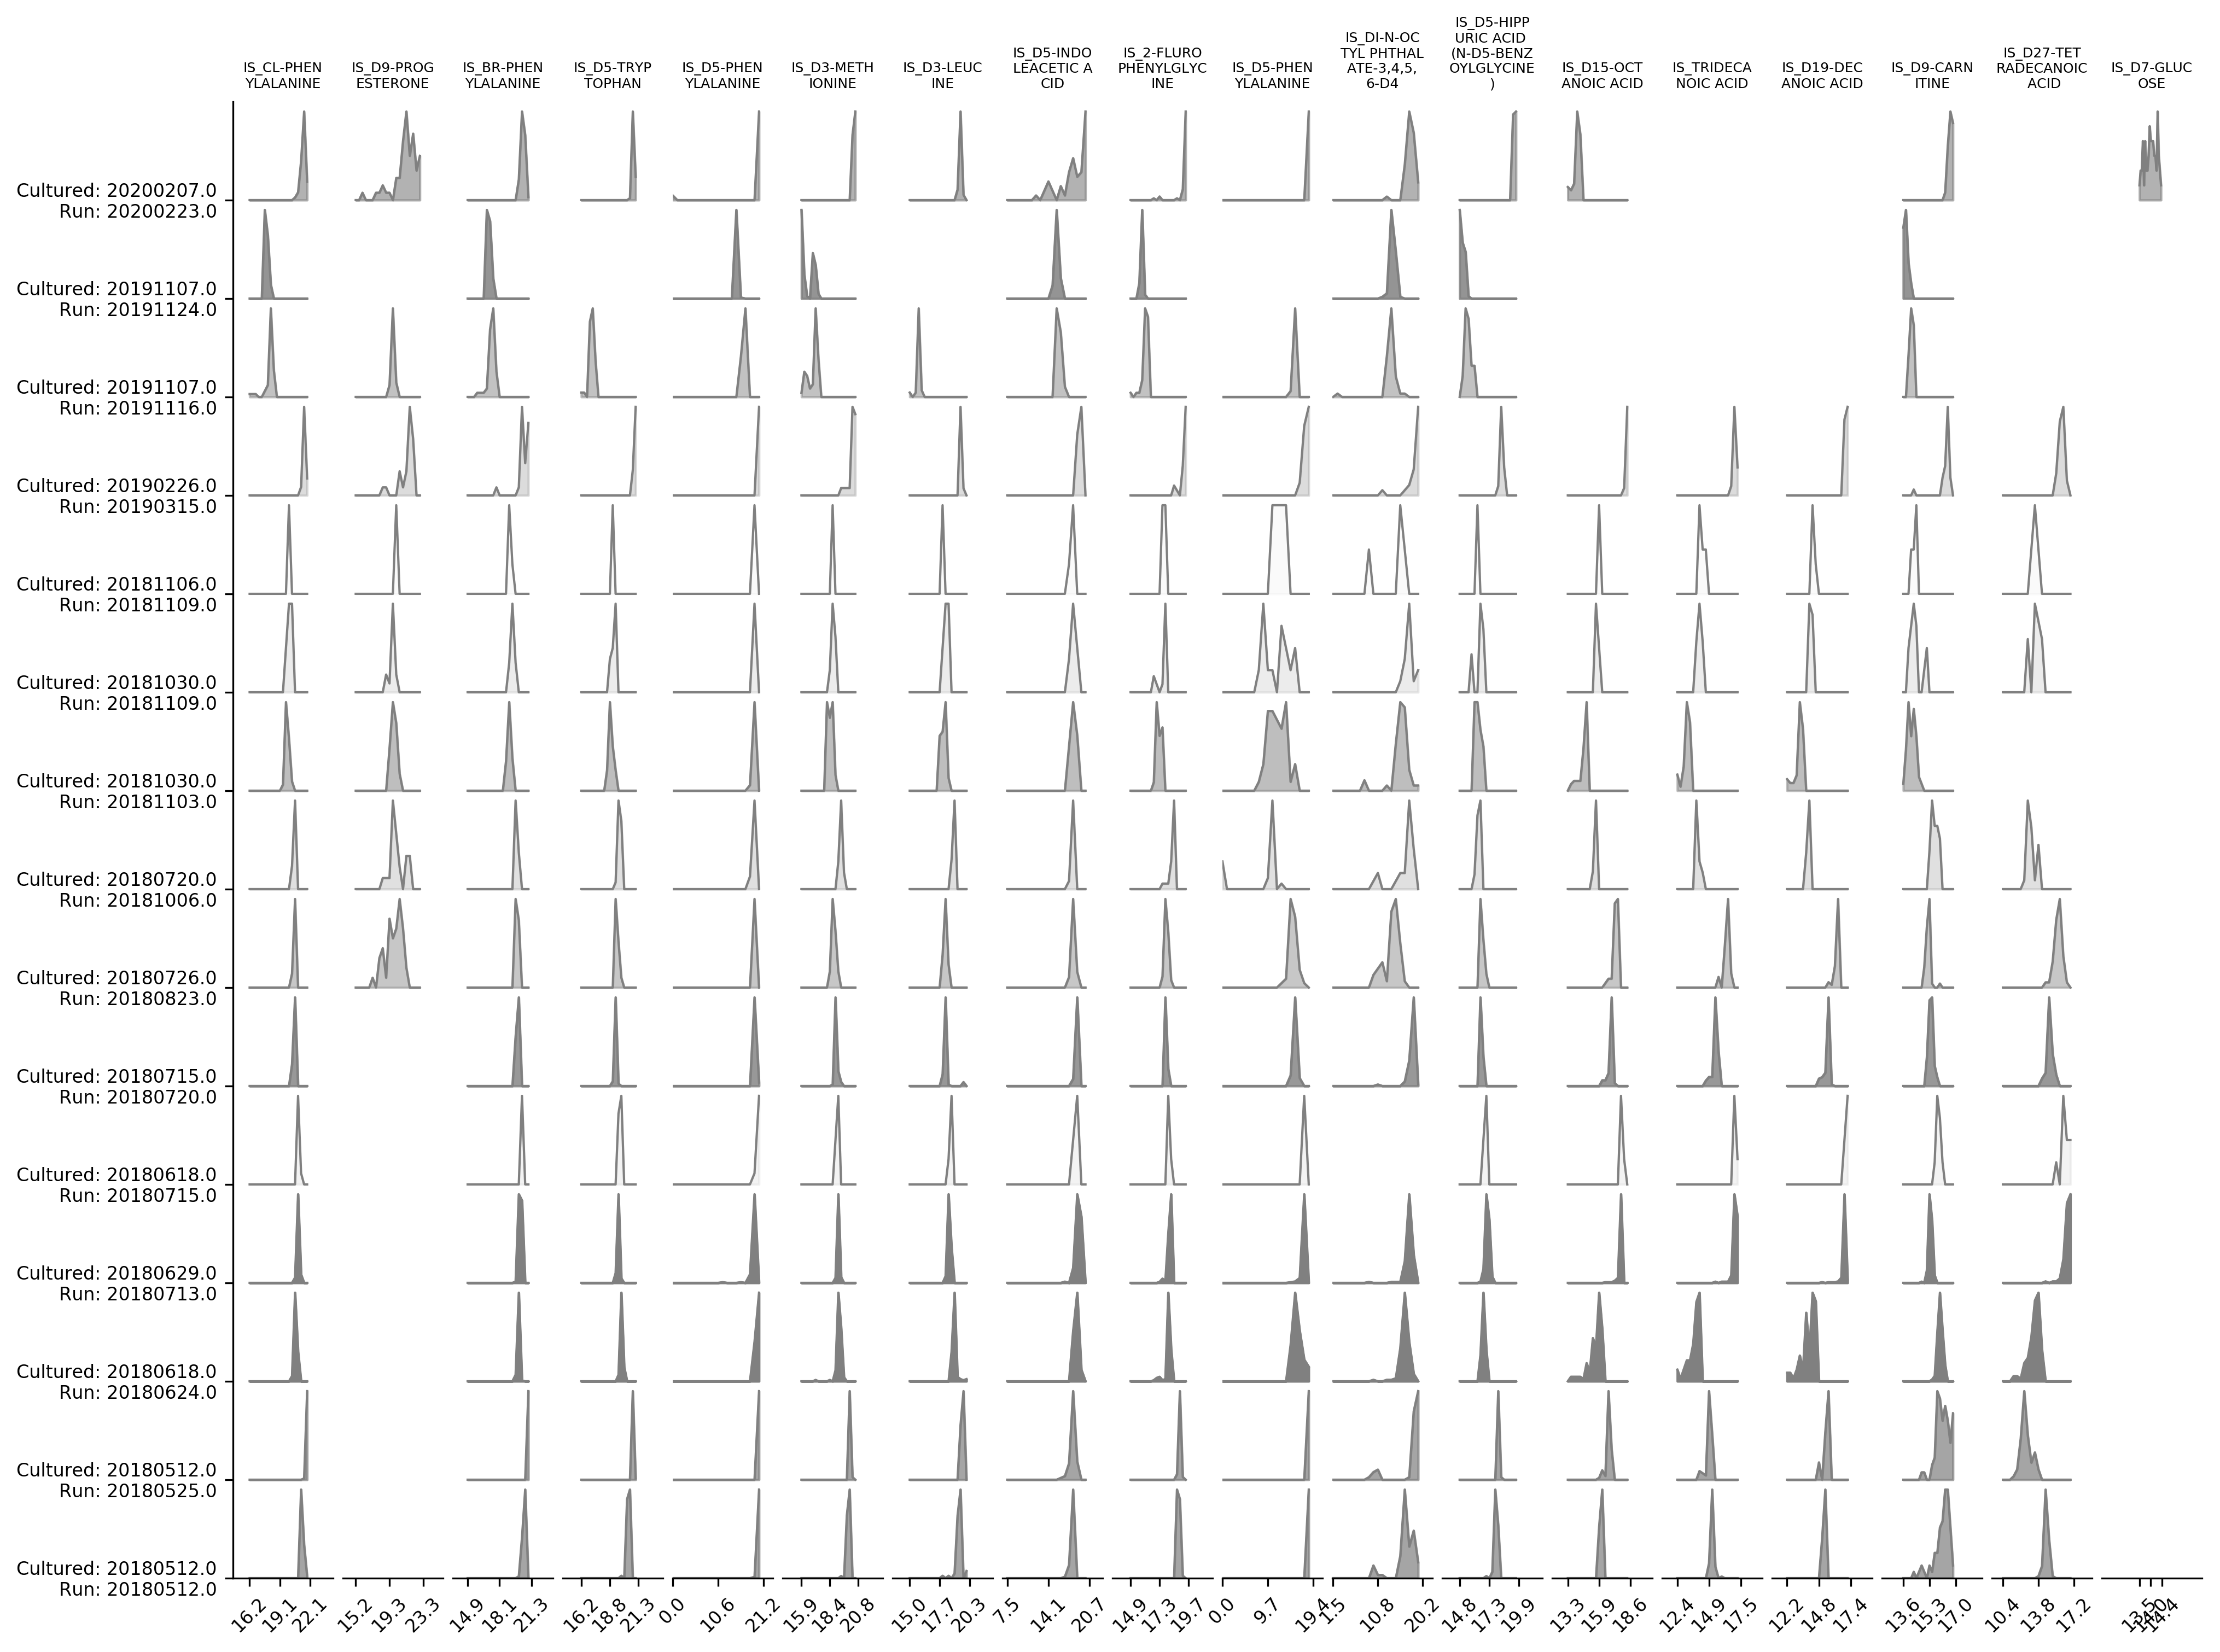

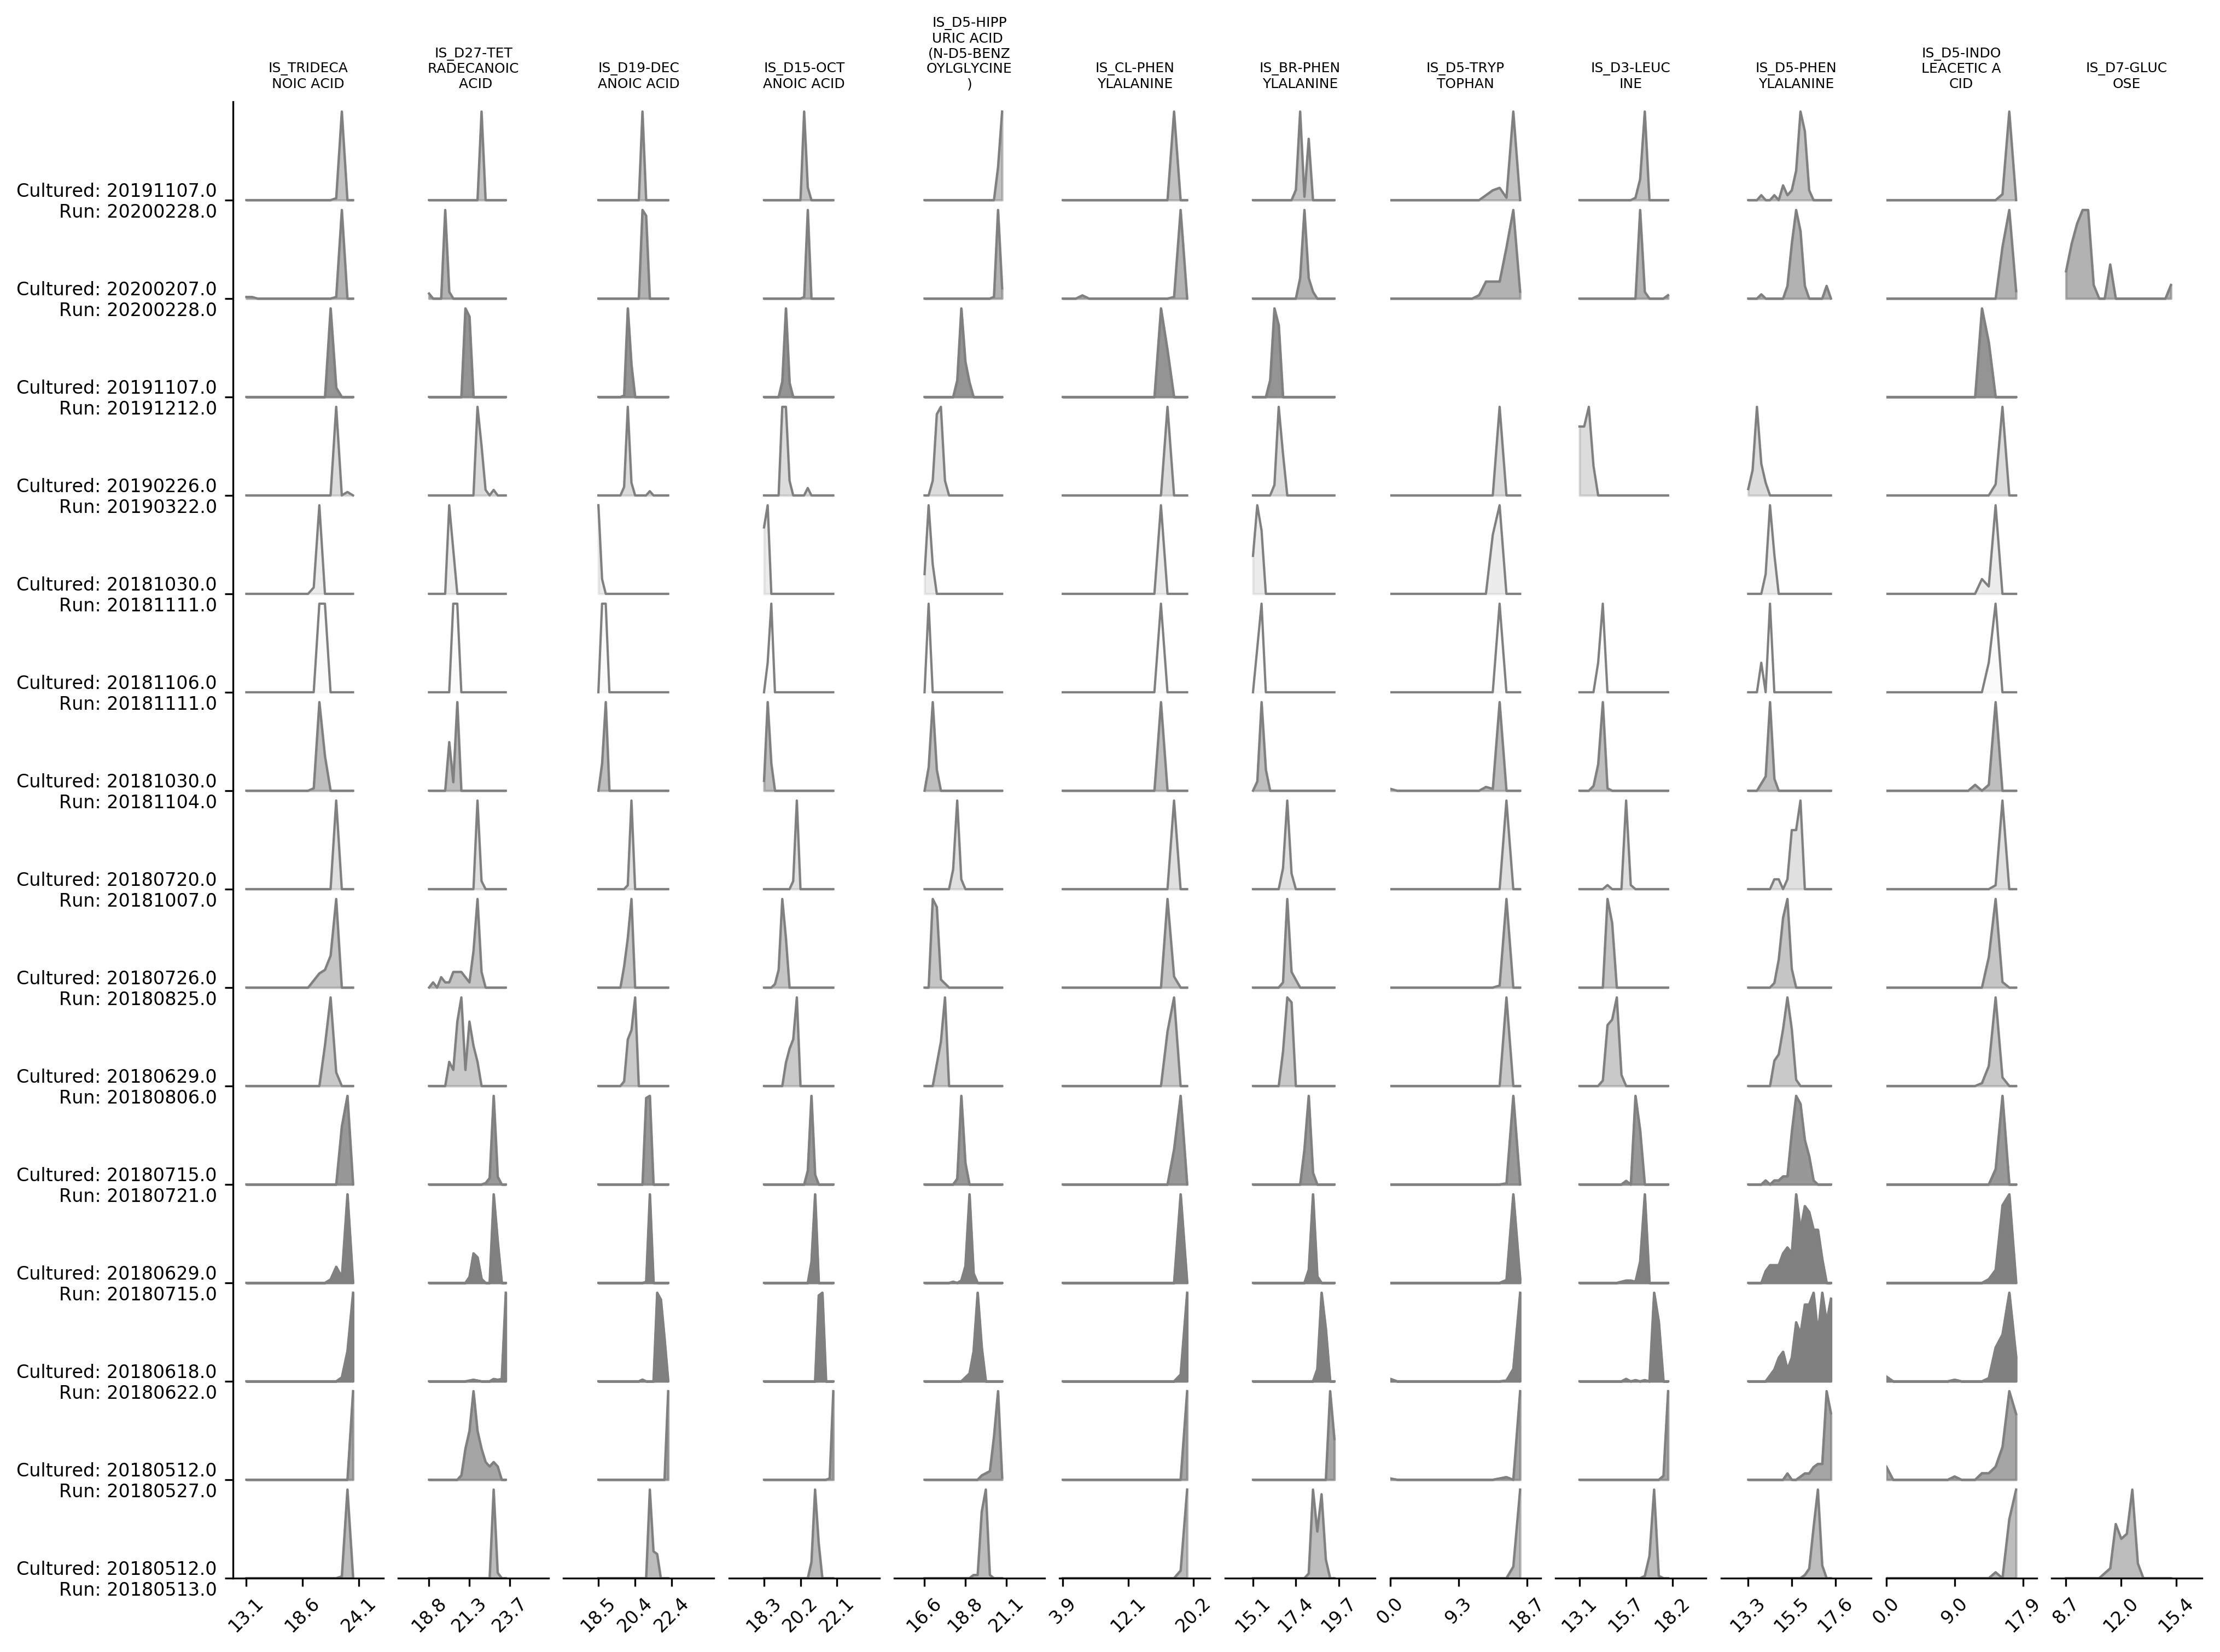

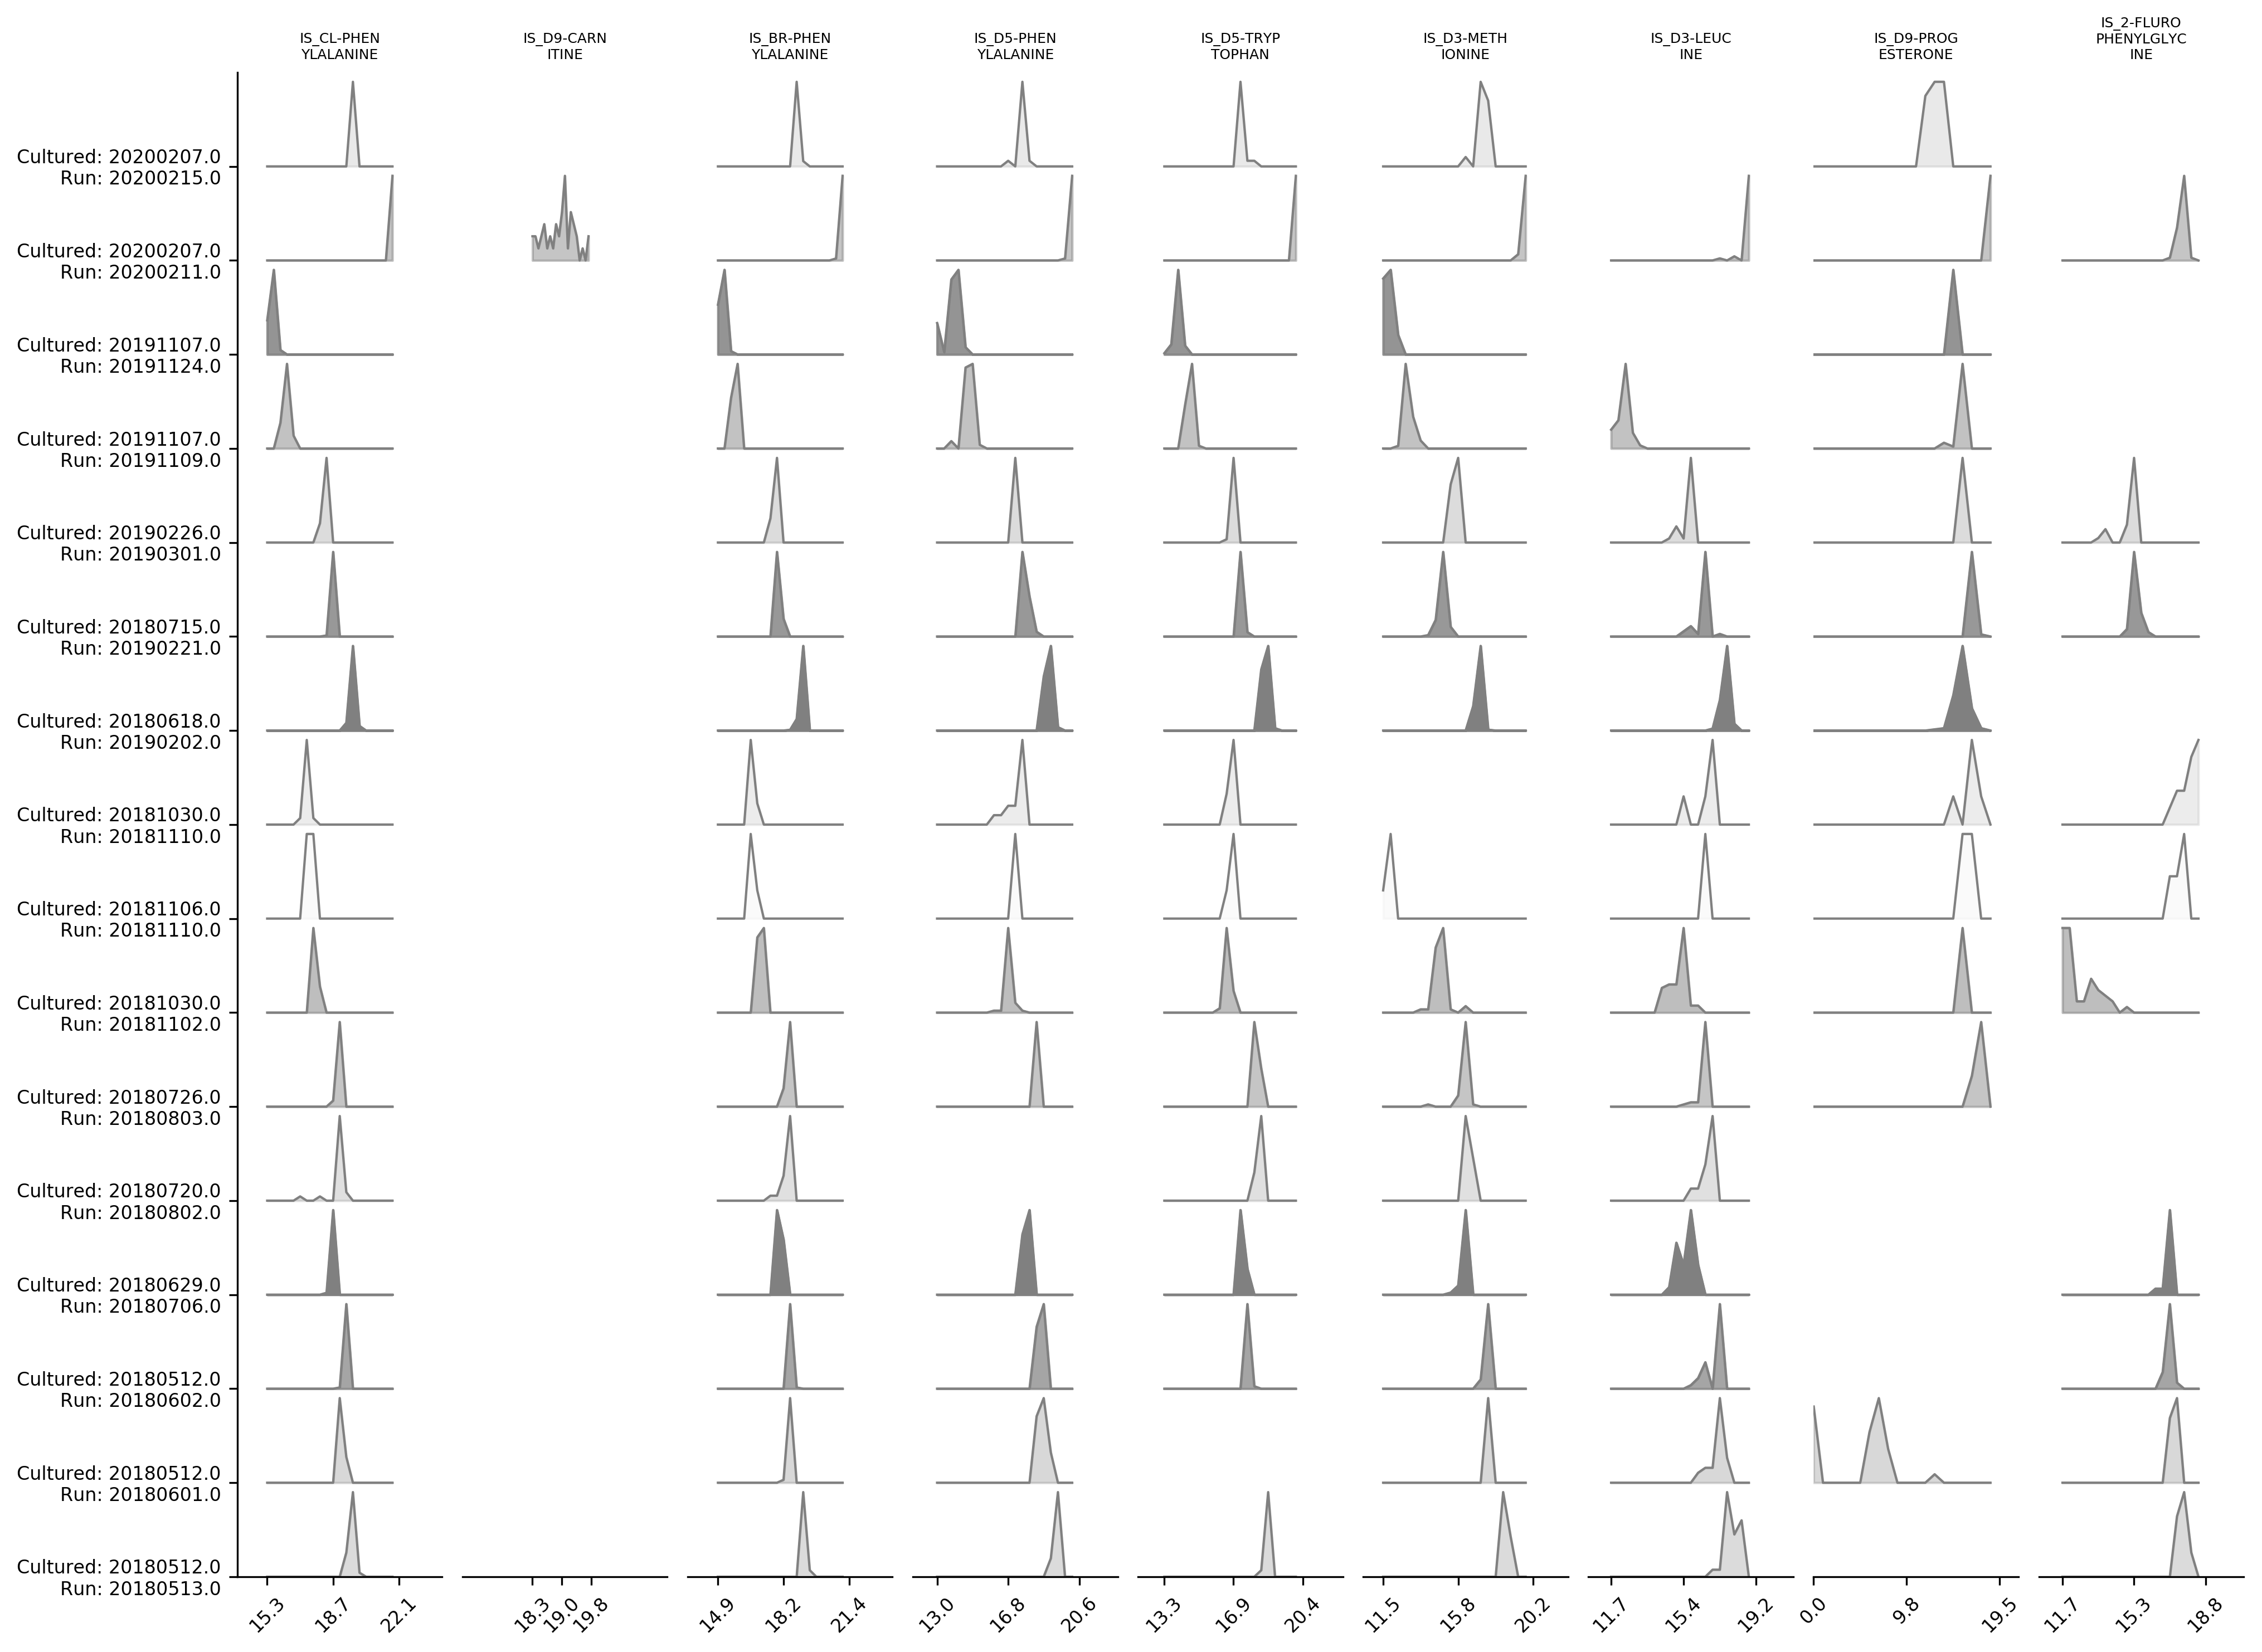

In [17]:
# To visualize what the ISTDs look like per experiment
%matplotlib inline

def long_label_splitter(s, max_width=30):
    if len(s) < max_width:
       return s
    else:
        length_remaining = len(s)
        pieces = []
        while length_remaining != 0:
            pieces.append(s[:max_width])
            s = s[max_width:]
            length_remaining = len(s)
        return '\n'.join(pieces)

ISTDS_BY_MODE = {'c18positive': ['m_c18p_0554',
                                'm_c18p_0555',
                                'm_c18p_0556',
                                'm_c18p_0557',
                                'm_c18p_0558',
                                'm_c18p_0559',
                                'm_c18p_0560',
                                'm_c18p_0561',
                                'm_c18p_0562',
                                'm_c18p_0563',
                                'm_c18p_0564',
                                'm_c18p_0565',
                                'm_c18p_0566',
                                'm_c18p_0567',
                                'm_c18p_0568',
                                'm_c18p_0569',
                                'm_c18p_0570',
                                'm_c18p_0571'],
                'c18negative': ['m_c18n_0553',
                                'm_c18n_0554',
                                'm_c18n_0555',
                                'm_c18n_0556',
                                'm_c18n_0557',
                                'm_c18n_0558',
                                'm_c18n_0559',
                                'm_c18n_0560',
                                'm_c18n_0561',
                                'm_c18n_0562',
                                'm_c18n_0563',
                                'm_c18n_0564',
                                'm_c18n_0565',
                                'm_c18n_0566'],
                'hilicpositive': ['m_hilicp_0357',
                                  'm_hilicp_0358',
                                  'm_hilicp_0359',
                                  'm_hilicp_0360',
                                  'm_hilicp_0361',
                                  'm_hilicp_0362',
                                  'm_hilicp_0363',
                                  'm_hilicp_0364',
                                  'm_hilicp_0365',
                                  'm_hilicp_0366',
                                  'm_hilicp_0368']}
DNAME_TO_ISTD = {'m_c18n_0553': 'IS_D7-GLUCOSE',
                 'm_c18n_0554': 'IS_2-FLUROPHENYLGLYCINE',
                 'm_c18n_0555': 'IS_D3-METHIONINE',
                 'm_c18n_0556': 'IS_D3-LEUCINE',
                 'm_c18n_0557': 'IS_D5-TRYPTOPHAN',
                 'm_c18n_0558': 'IS_D5-HIPPURIC ACID (N-D5-BENZOYLGLYCINE)',
                 'm_c18n_0559': 'IS_CL-PHENYLALANINE',
                 'm_c18n_0560': 'IS_BR-PHENYLALANINE',
                 'm_c18n_0561': 'IS_D5-INDOLEACETIC ACID',
                 'm_c18n_0562': 'IS_D15-OCTANOIC ACID',
                 'm_c18n_0563': 'IS_D19-DECANOIC ACID',
                 'm_c18n_0564': 'IS_TRIDECANOIC ACID',
                 'm_c18n_0565': 'IS_D27-TETRADECANOIC ACID',
                 'm_c18n_0566': 'IS_D5-PHENYLALANINE',
                 'm_c18p_0554': 'IS_D9-CARNITINE',
                 'm_c18p_0555': 'IS_D7-GLUCOSE',
                 'm_c18p_0556': 'IS_2-FLUROPHENYLGLYCINE',
                 'm_c18p_0557': 'IS_D3-METHIONINE',
                 'm_c18p_0558': 'IS_D3-LEUCINE',
                 'm_c18p_0559': 'IS_D5-PHENYLALANINE',
                 'm_c18p_0560': 'IS_D5-PHENYLALANINE',
                 'm_c18p_0561': 'IS_D5-TRYPTOPHAN',
                 'm_c18p_0562': 'IS_D5-HIPPURIC ACID (N-D5-BENZOYLGLYCINE)',
                 'm_c18p_0563': 'IS_CL-PHENYLALANINE',
                 'm_c18p_0564': 'IS_BR-PHENYLALANINE',
                 'm_c18p_0565': 'IS_D5-INDOLEACETIC ACID',
                 'm_c18p_0566': 'IS_D15-OCTANOIC ACID',
                 'm_c18p_0567': 'IS_D9-PROGESTERONE',
                 'm_c18p_0568': 'IS_D19-DECANOIC ACID',
                 'm_c18p_0569': 'IS_DI-N-OCTYL PHTHALATE-3,4,5,6-D4',
                 'm_c18p_0570': 'IS_TRIDECANOIC ACID',
                 'm_c18p_0571': 'IS_D27-TETRADECANOIC ACID',
                 'm_hilicp_0357': 'IS_D9-CARNITINE',
                 'm_hilicp_0358': 'IS_2-FLUROPHENYLGLYCINE',
                 'm_hilicp_0359': 'IS_D3-METHIONINE',
                 'm_hilicp_0360': 'IS_D3-LEUCINE',
                 'm_hilicp_0361': 'IS_D5-TRYPTOPHAN',
                 'm_hilicp_0362': 'IS_CL-PHENYLALANINE',
                 'm_hilicp_0363': 'IS_BR-PHENYLALANINE',
                 'm_hilicp_0364': 'IS_D5-INDOLEACETIC ACID',
                 'm_hilicp_0365': 'IS_D9-PROGESTERONE',
                 'm_hilicp_0366': 'IS_D5-PHENYLALANINE',
                 'm_hilicp_0368': 'IS_L-4-HYDROXYPHENYL-D4-ALANINE_PEAK2'}

def _find_bin_range(msdata, groups, centiles_to_test=[1,99]):
    results = []
    for col in msdata.columns:
        lb = np.inf
        ub = 0
        for _, samples in groups.items():
            _lb, _ub = np.percentile(msdata.loc[samples, col].values,
                                     centiles_to_test)
            lb = min(lb, _lb)
            ub = max(ub, _ub)
        results.append((col, lb, ub))
    return results

def _xaxis_labels(br):
    locs = [br[1], br[1] + (br[2] - br[1]) / 2., br[2]]
    return (np.array(locs), np.round(locs, 1))


md_fp = 'supplemental_table_5.xlsx'
full_md = pd.read_excel(io=md_fp, index_col=0, sheet_name='mf')

modes = ('c18positive', 'c18negative', 'hilicpositive')
fps = ('bacterial_supernatant_data/c18positive_data.txt', 
       'bacterial_supernatant_data/c18negative_data.txt', 
       'bacterial_supernatant_data/hilicpositive_data.txt')

for mode, fp in zip(modes, fps):

    mode_msdata = pd.read_csv(fp, sep='\t', index_col=0)

    # Select samples that are media blanks or supernatants from mega media only.
    idxs = (((full_md['sample_type'] == 'supernatant') |
             (full_md['sample_type'] == 'media_blank')) &
            (full_md['media'] == 'mm') &
            (full_md['mode'] == mode))
    mode_md = full_md.loc[idxs, :].copy()

    # Identify which samples we actually have msdata for.
    overlap = sorted(set(mode_msdata.index).intersection(mode_md.index))

    # Final data + log transform to make comparison easier.
    mode_md = mode_md.loc[overlap, :].copy()
    mode_msdata = mode_msdata.loc[overlap, :].copy()

    # The istds we'll use. Check that the ISTDs possible in this mode are in
    # the msdata we have. Also check that even if an ISTD is a column that it
    # is not nan at least once
    _istds = np.array(ISTDS_BY_MODE[mode])
    _istds = _istds[np.in1d(_istds, mode_msdata.columns)]
    istds = _istds[mode_msdata.loc[:, _istds].notnull().any(0).values]
    n_istds = len(istds)

    ## Transform the msdata
    # Choose only istds
    istd_msdata = mode_msdata.loc[:, istds]
    # Remove any ISTDs that are always nan (never found)
    # msdata = msdata.loc[:, msdata.notnull().any(0).values]


    # Sort so that largest ISTDs first.
    istd_msdata = istd_msdata.loc[:, istd_msdata.mean(0).sort_values(ascending=False).index]
    # Log2 for comparability
    istd_msdata = np.log2(1 + istd_msdata)

    gb = ['preculture_date', 'lcms_run_date']
    groups = mode_md.groupby(gb).groups
    n_groups = len(groups)

    exps_in_order = sorted(groups.keys(), key=lambda x: x[1])

    fig, axarr = plt.subplots(ncols=n_istds, sharey=False, figsize=(15, 10),
                              dpi=300)

    # This is a very important step. We want to make sure we have a bin range
    # which captures the range of the data for each experiment, but we also
    # want this to be as narrow as possible so that we can see the variation
    # visually. The function below loops through the samples in each exp and
    # finds a bin range that captures the inner 96% of the data. It then
    # selects the min lb and max ub across all experiments. Thus, this excludes
    # at most n_exps * 4% of the data (if all data had exact same centiles)
    # and balances showing most of the data with a smaller range that allows
    # comparison.
    bin_ranges = _find_bin_range(istd_msdata, groups, centiles_to_test=[1,99])

    for y_baseline, exp_key in enumerate(exps_in_order):
        exp_samples = groups[exp_key]
        tmp = istd_msdata.loc[exp_samples, :]

        for mpl_col_idx, col in enumerate(tmp.values.T):
            # Skip ISTDS that are null for this exp
            if np.isnan(col).all():
                pass
            else:
                bins = np.linspace(bin_ranges[mpl_col_idx][1],
                                   bin_ranges[mpl_col_idx][2],
                                   21)
                # We'll communicate the number of values with the shading of
                # the fill between.
                _nan_idxs = np.isnan(col)
                _count_nan = _nan_idxs.sum()
                _real_frac = (col.shape[0] - _count_nan) / col.shape[0]
                counts, _ = np.histogram(col[~_nan_idxs], bins)
                #color = (0.5, 0.5, 0.5, col.shape[0]/256.) #, _real_frac)
                color = (0.5, 0.5, 0.5, min(1.0, col.shape[0]/100))
                # Adjust yloc of plot so that histograms dont' overlap and have a max
                # height of 1.
                ylocs = y_baseline + 0.9 * (counts / counts.max())

                axarr[mpl_col_idx].plot(bins[:-1], ylocs, color='gray', lw=1, ls='-', ms=0)
                axarr[mpl_col_idx].fill_between(bins[:-1], ylocs, y_baseline, color=color)

    for _istd, br, ax in zip(istd_msdata.columns, bin_ranges, axarr):
        # Set axis limits
        ax.set_ylim(0, n_groups)
        ax.set_xlim(br[1]*0.9, br[2]*1.1)        
        # Set xticks
        xtick_locs, xtick_labels = _xaxis_labels(br)
        ax.set_xticks(xtick_locs)
        ax.set_xticklabels(xtick_labels, fontsize=8, rotation=45)
        # Title
        ax.set_title(long_label_splitter(DNAME_TO_ISTD[_istd], 10), fontsize=6)
        #ax.set_title(_istd, fontsize=6)

    for ax in axarr[1:]:
        for spine in ['left', 'right', 'top']:
            ax.spines[spine].set_visible(False)
        ax.set_yticks([])

    axarr[0].spines['right'].set_visible(False)
    axarr[0].spines['top'].set_visible(False)
    axarr[0].yaxis.tick_left()
    axarr[0].set_yticks(np.arange(0, n_groups))
    ylabels = ['Cultured: %s\nRun: %s' % (i, j) for i, j in exps_in_order]
    axarr[0].set_yticklabels(ylabels, fontsize=8)

    plt.subplots_adjust(left=0.1, wspace=0.1, bottom=0.05, top=0.95)

Here we examine what the PCA plots look like on a per-experiment basis. This helps us eliminate samples that have technical artifacts despite having high correlation coefficients with their replicates. Note that some of the samples we identify here are eliminated above (e.g. in `c18pos_lowcc_samples`). These eliminated samples are included here to illustrate why they needed to be removed (e.g. `s01559`). The reason for placing this code here rather than above is that we needed the ISTD TIC corrected data before we could confidently eliminate these samples. We could have removed them after this cell, but this notebook is an amalgam of different analytical pipelines and so the order of QC steps is approximated.

/Users/wdwvt/anaconda/envs/py3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/wdwvt/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:60: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


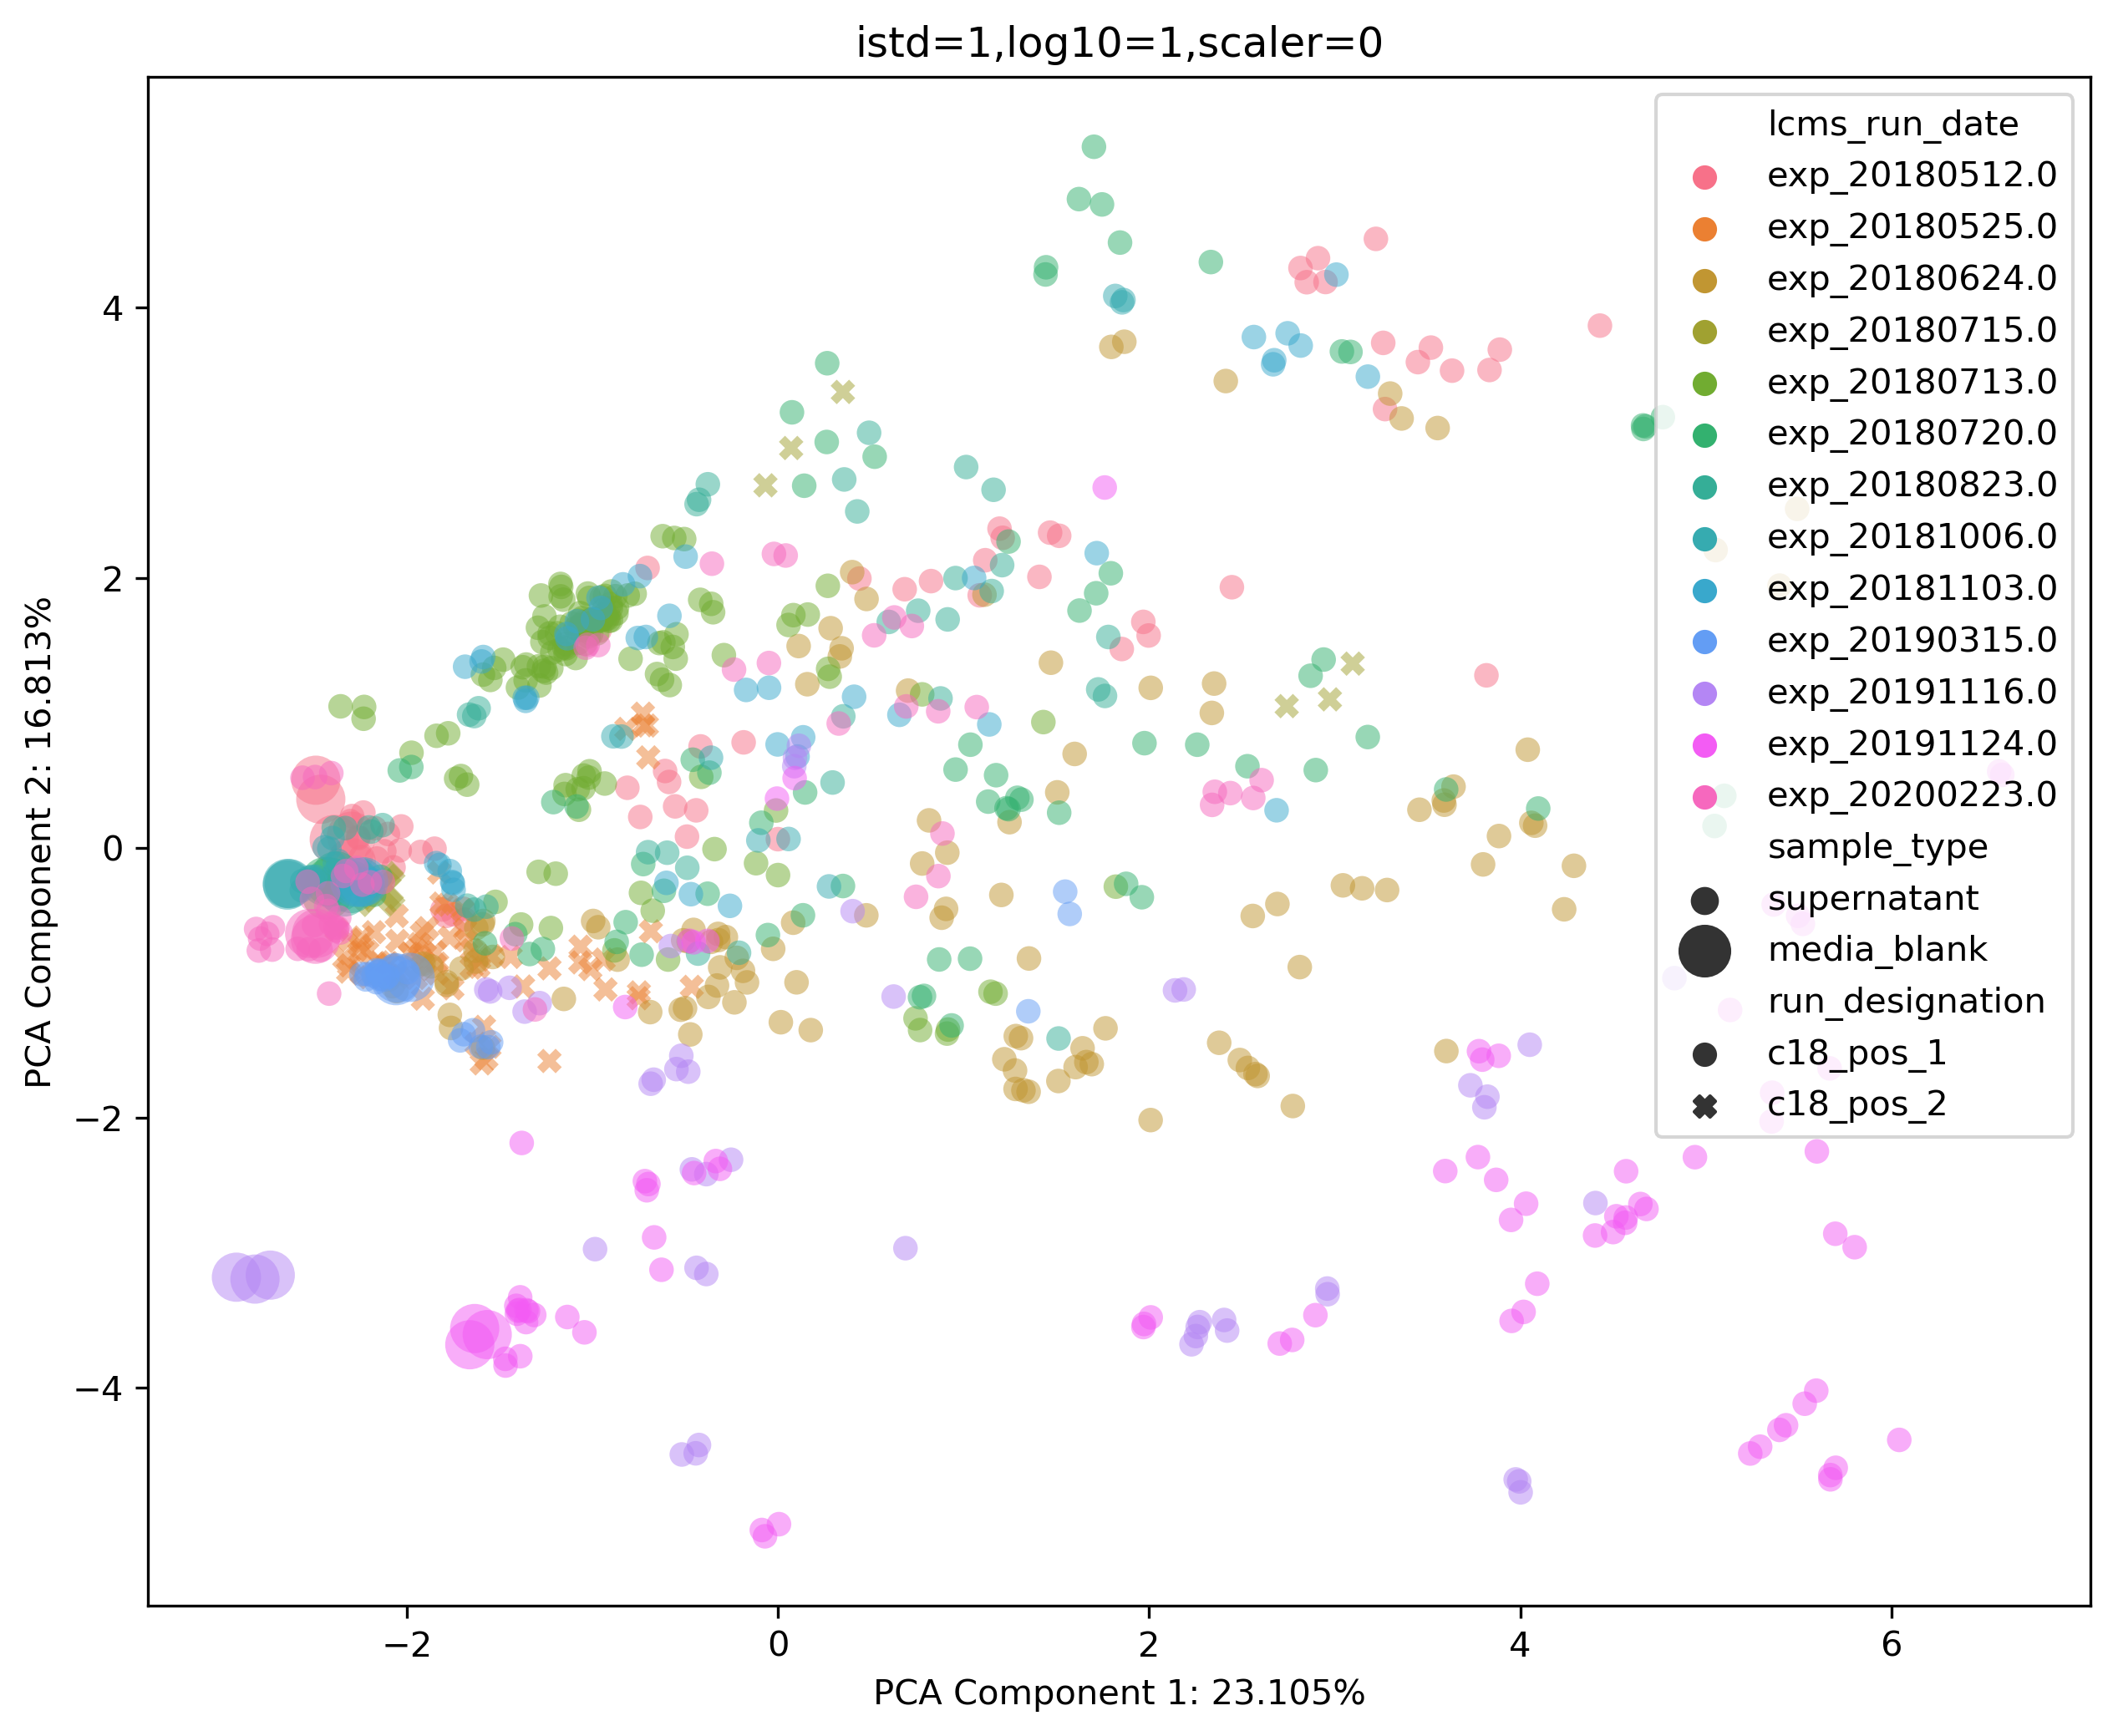

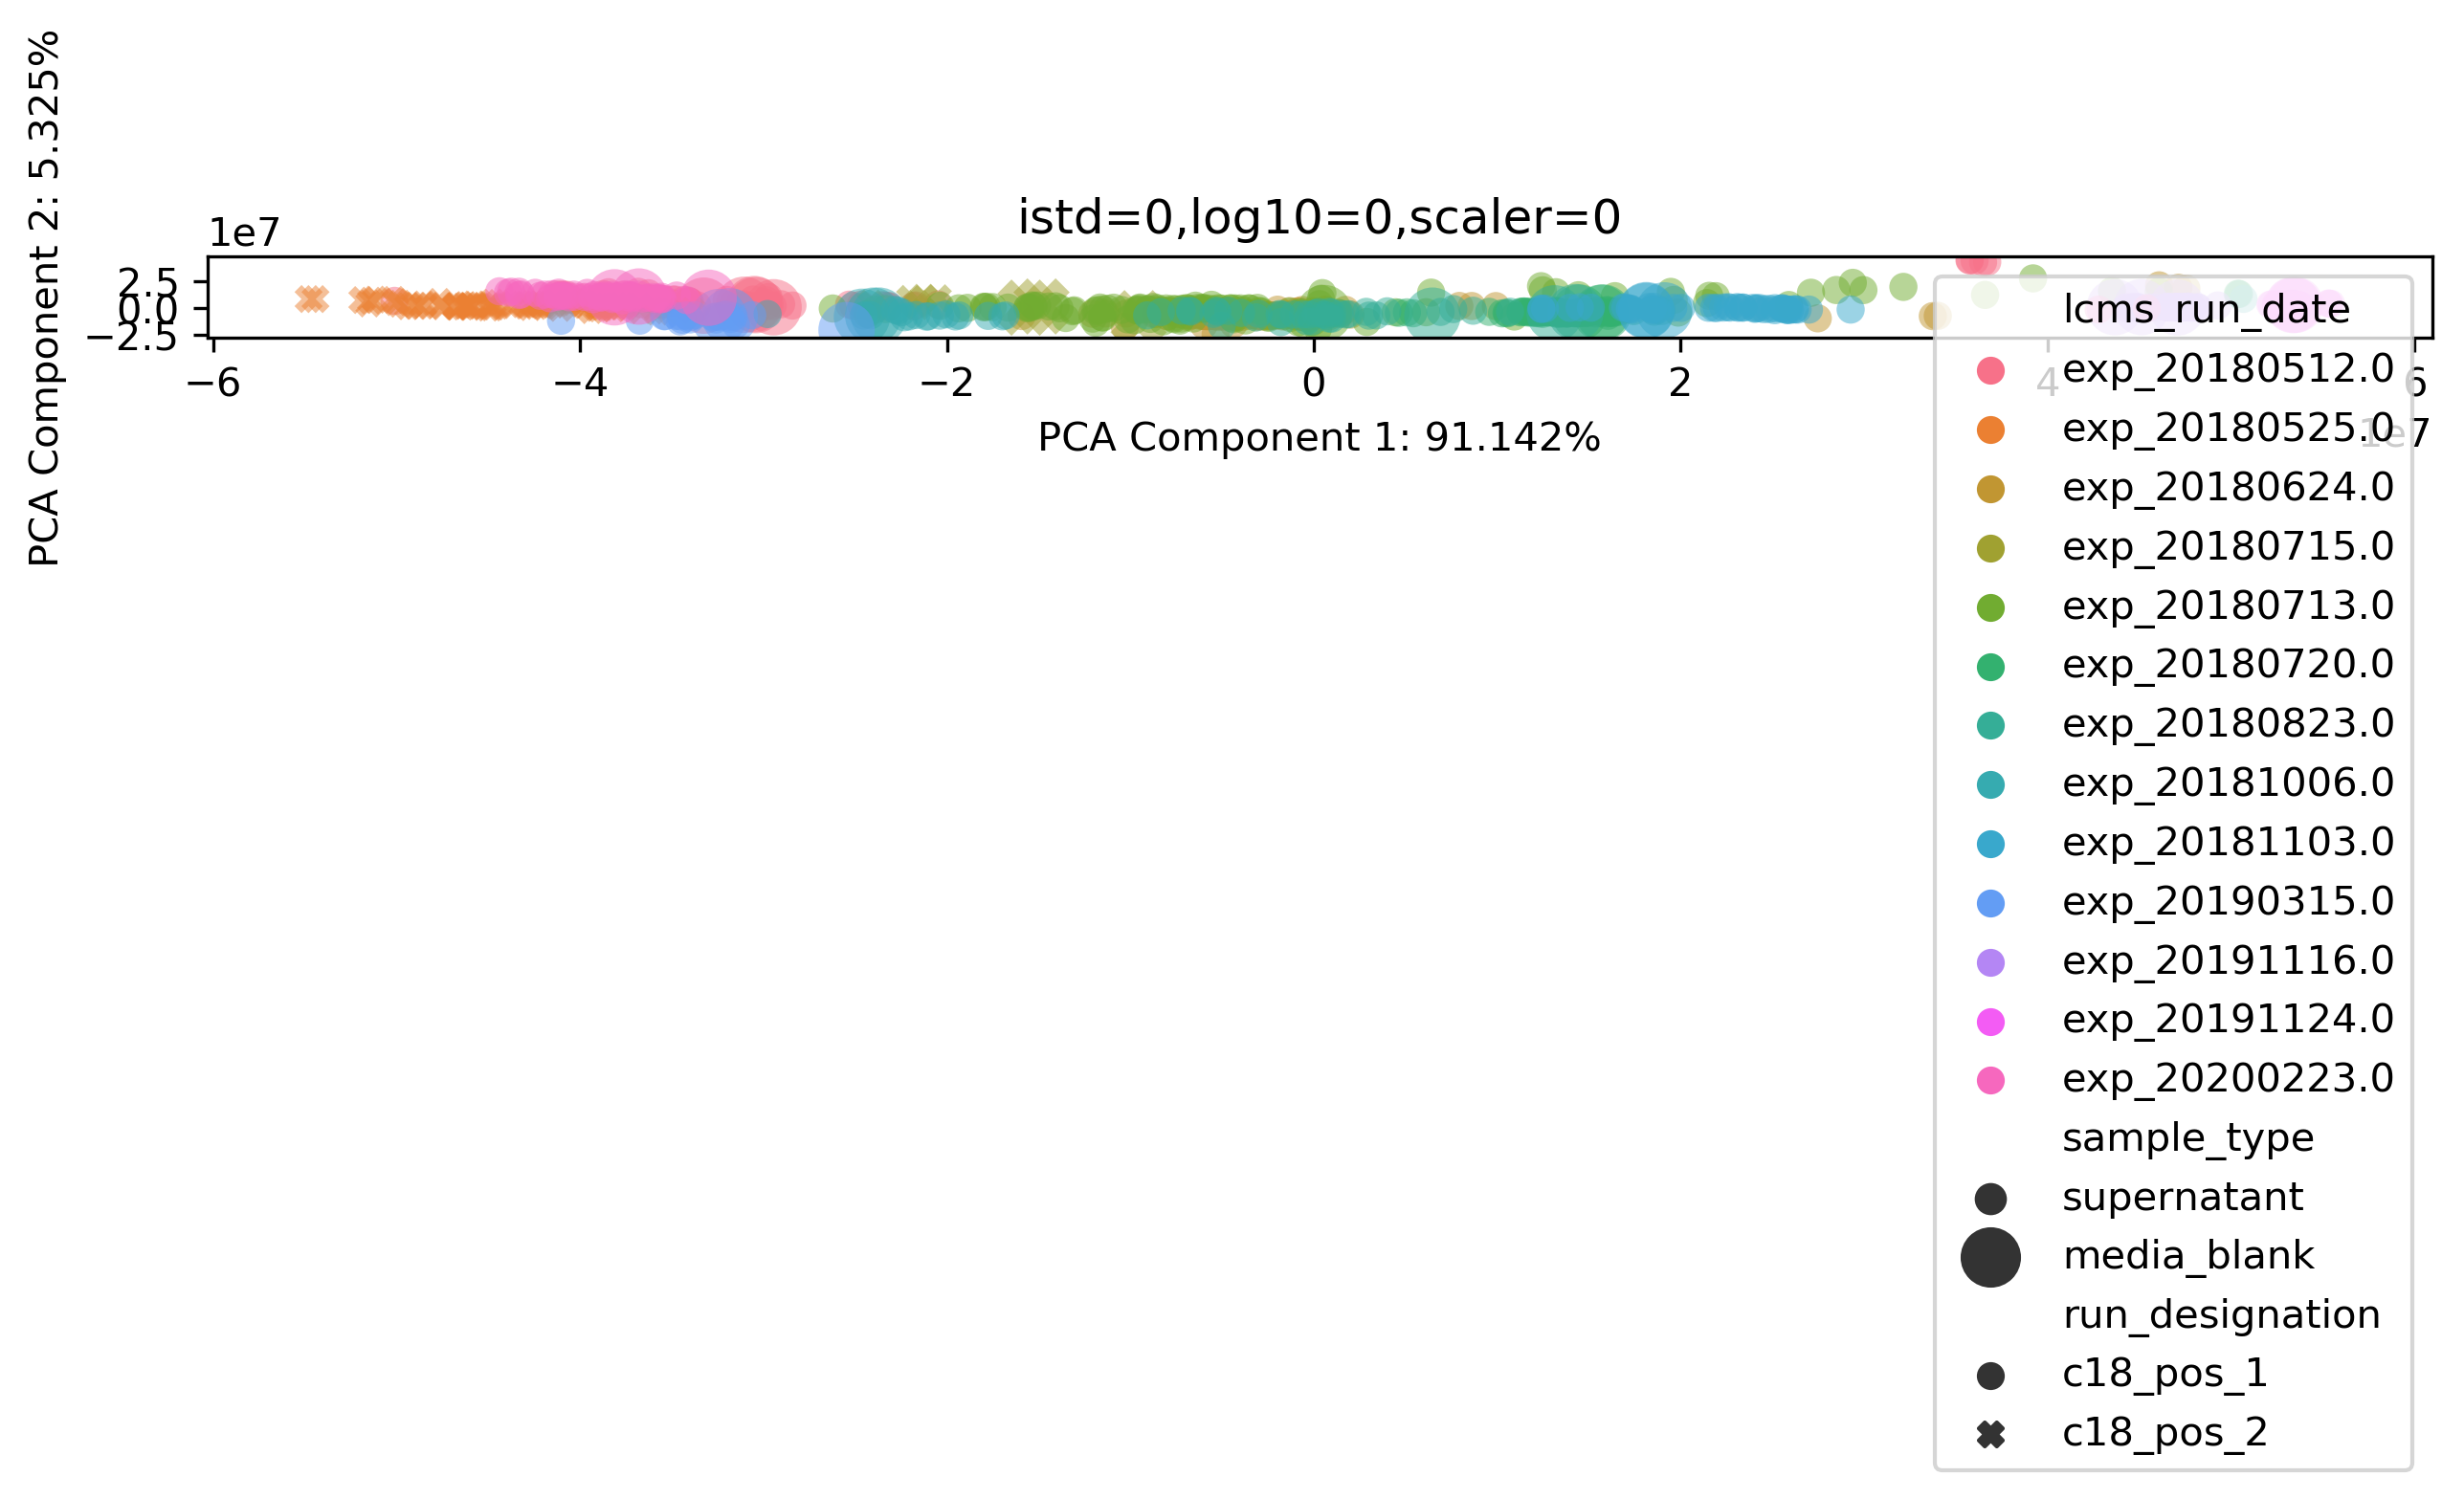

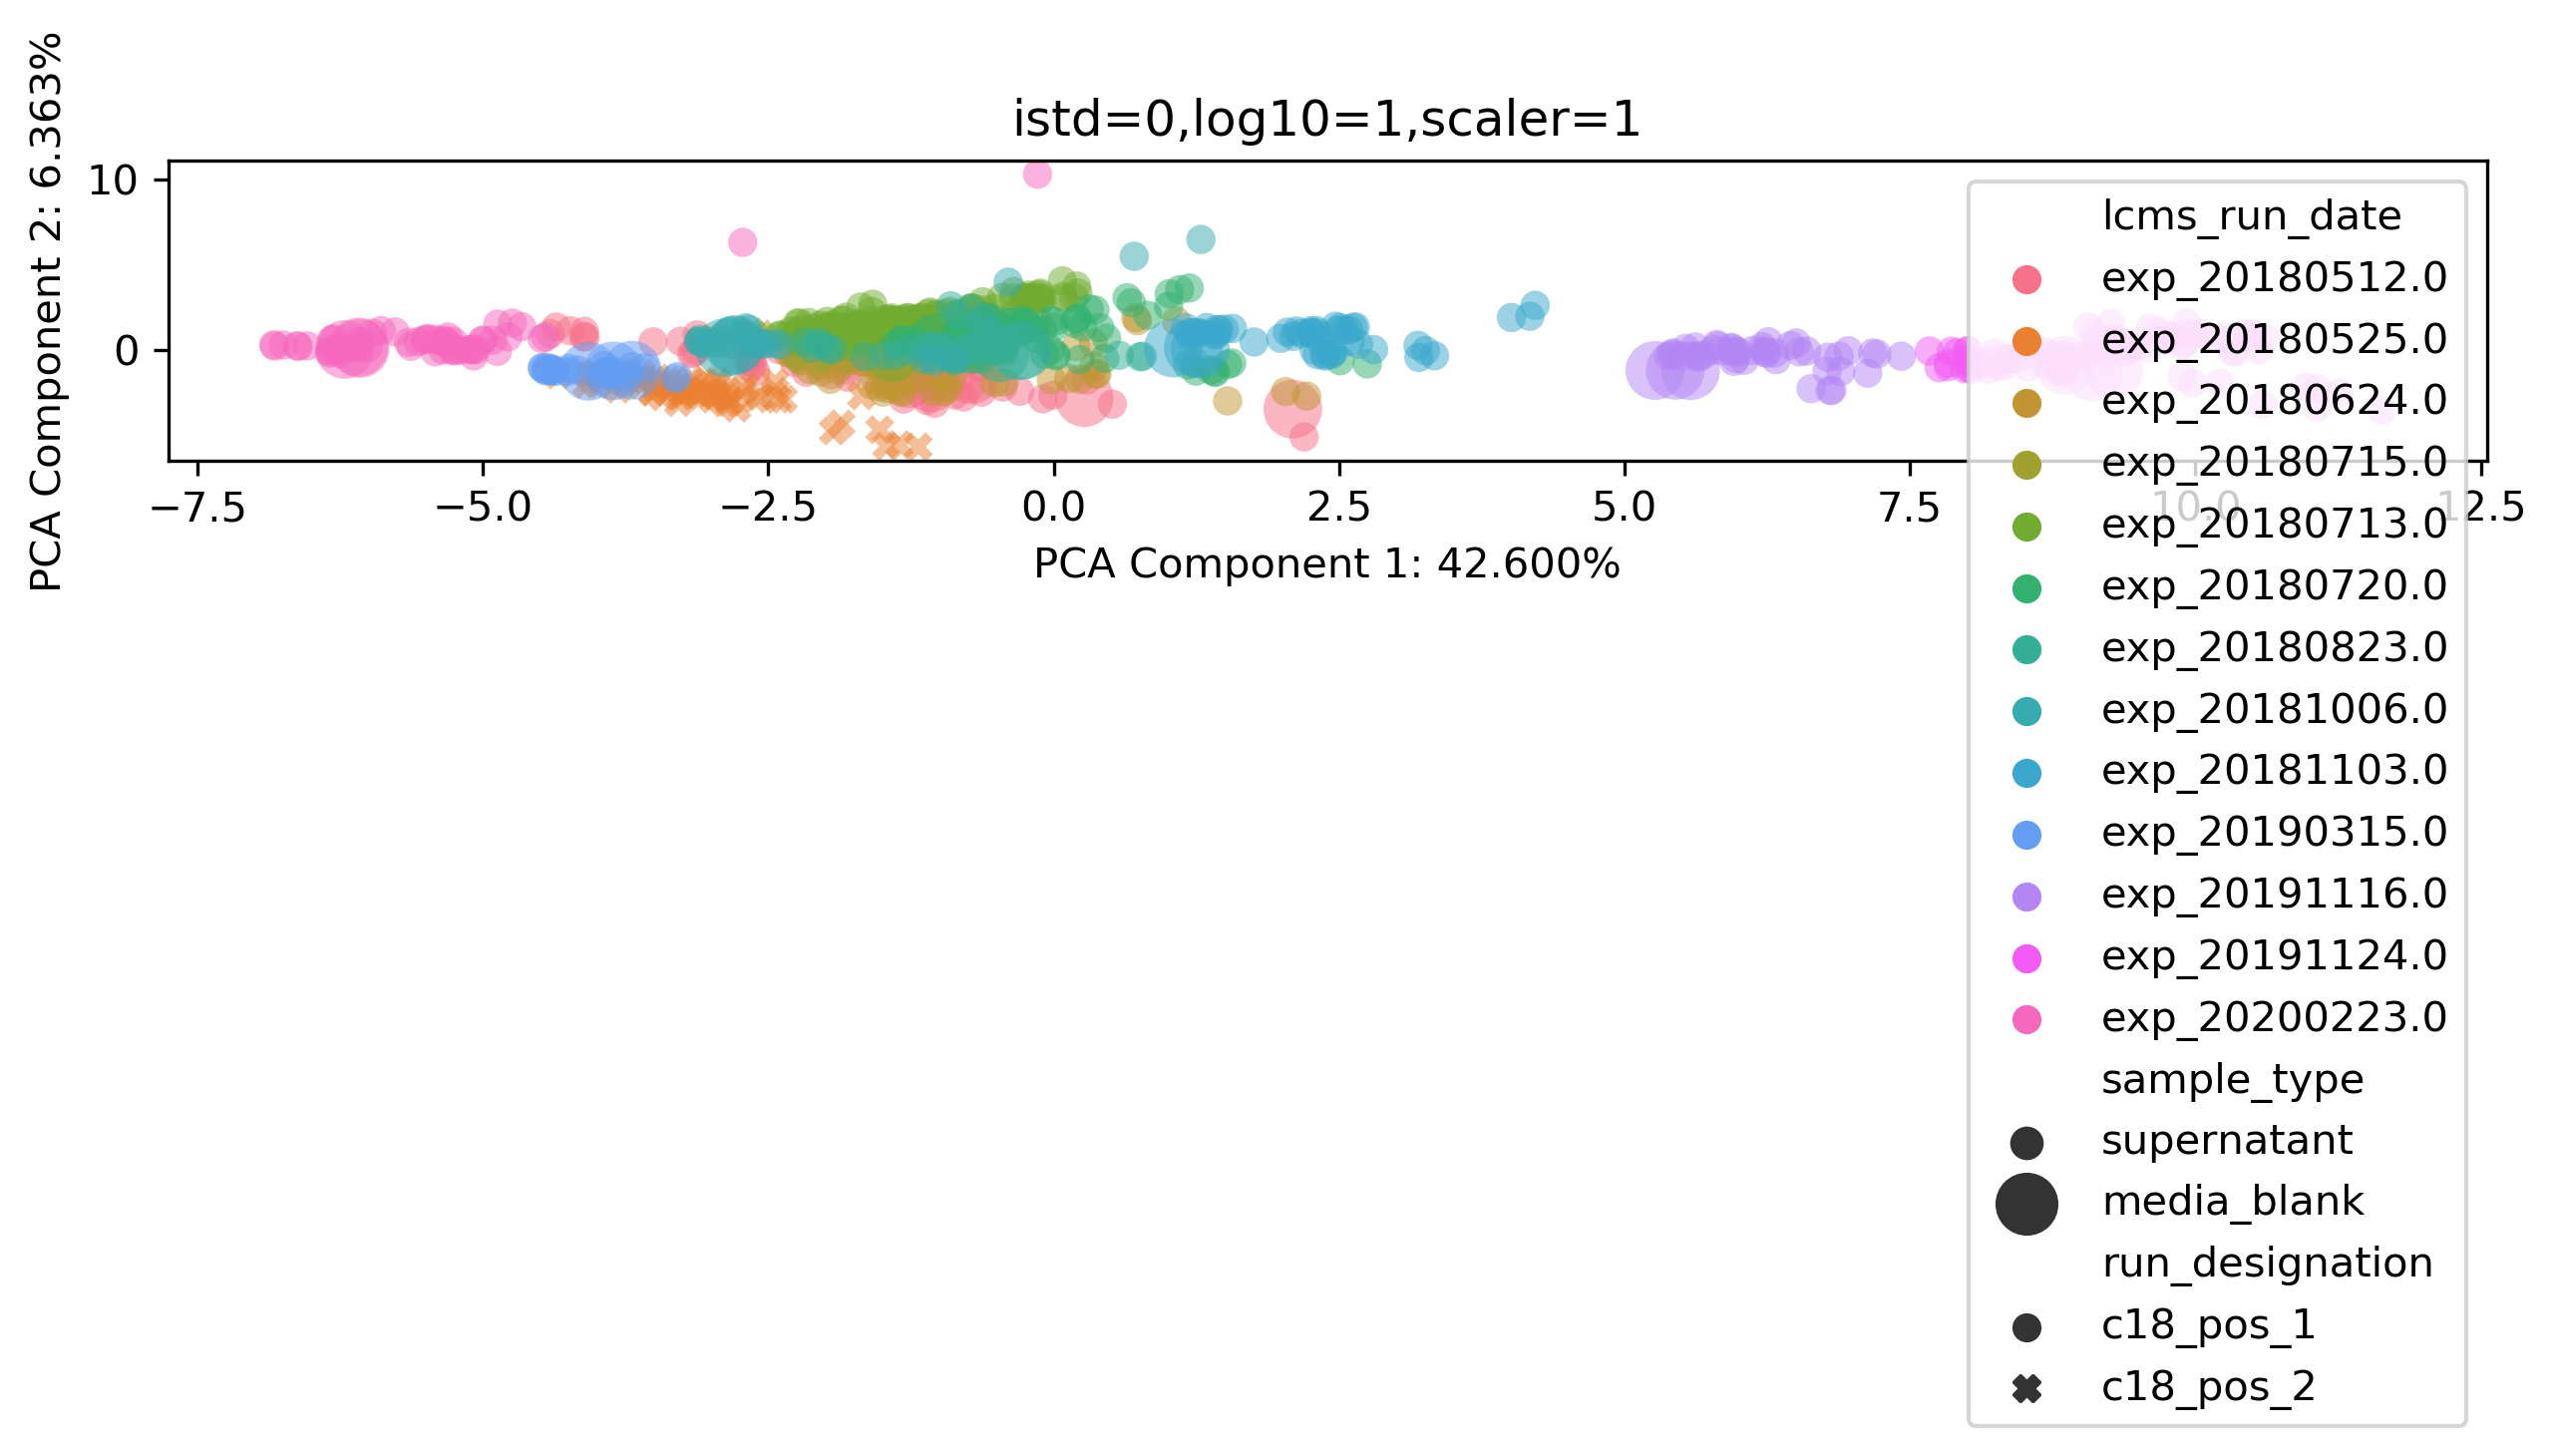

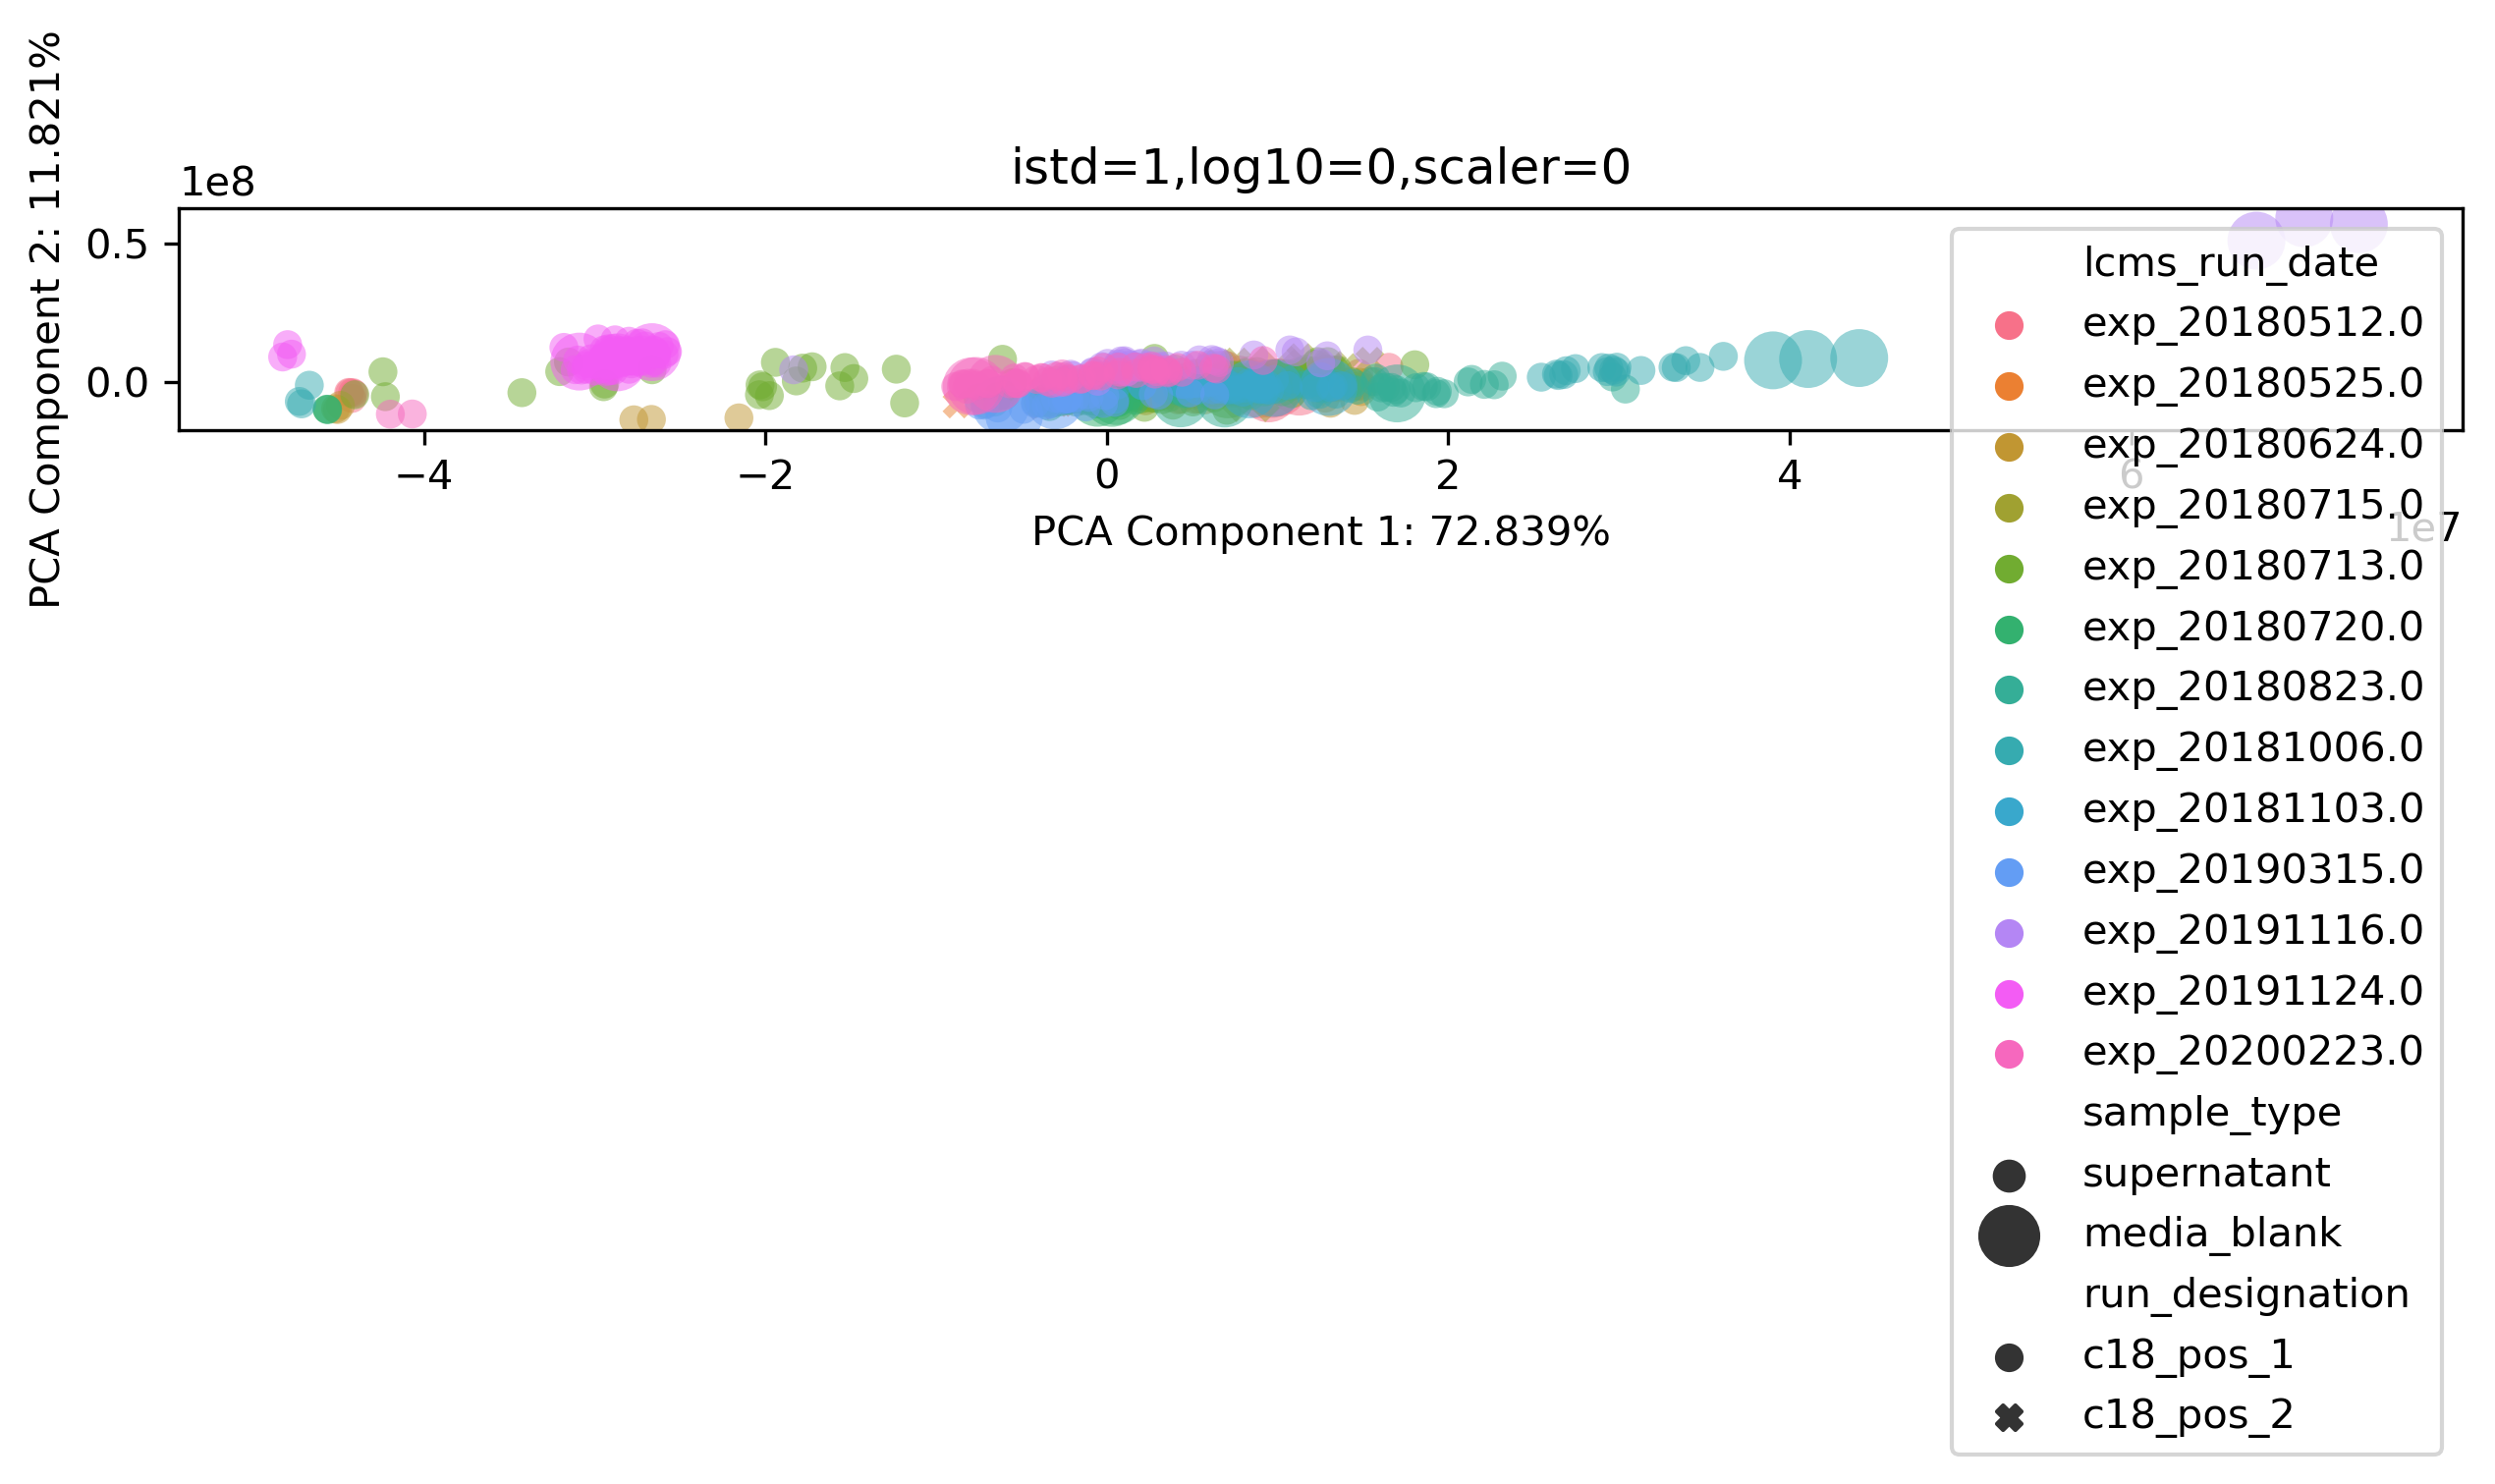

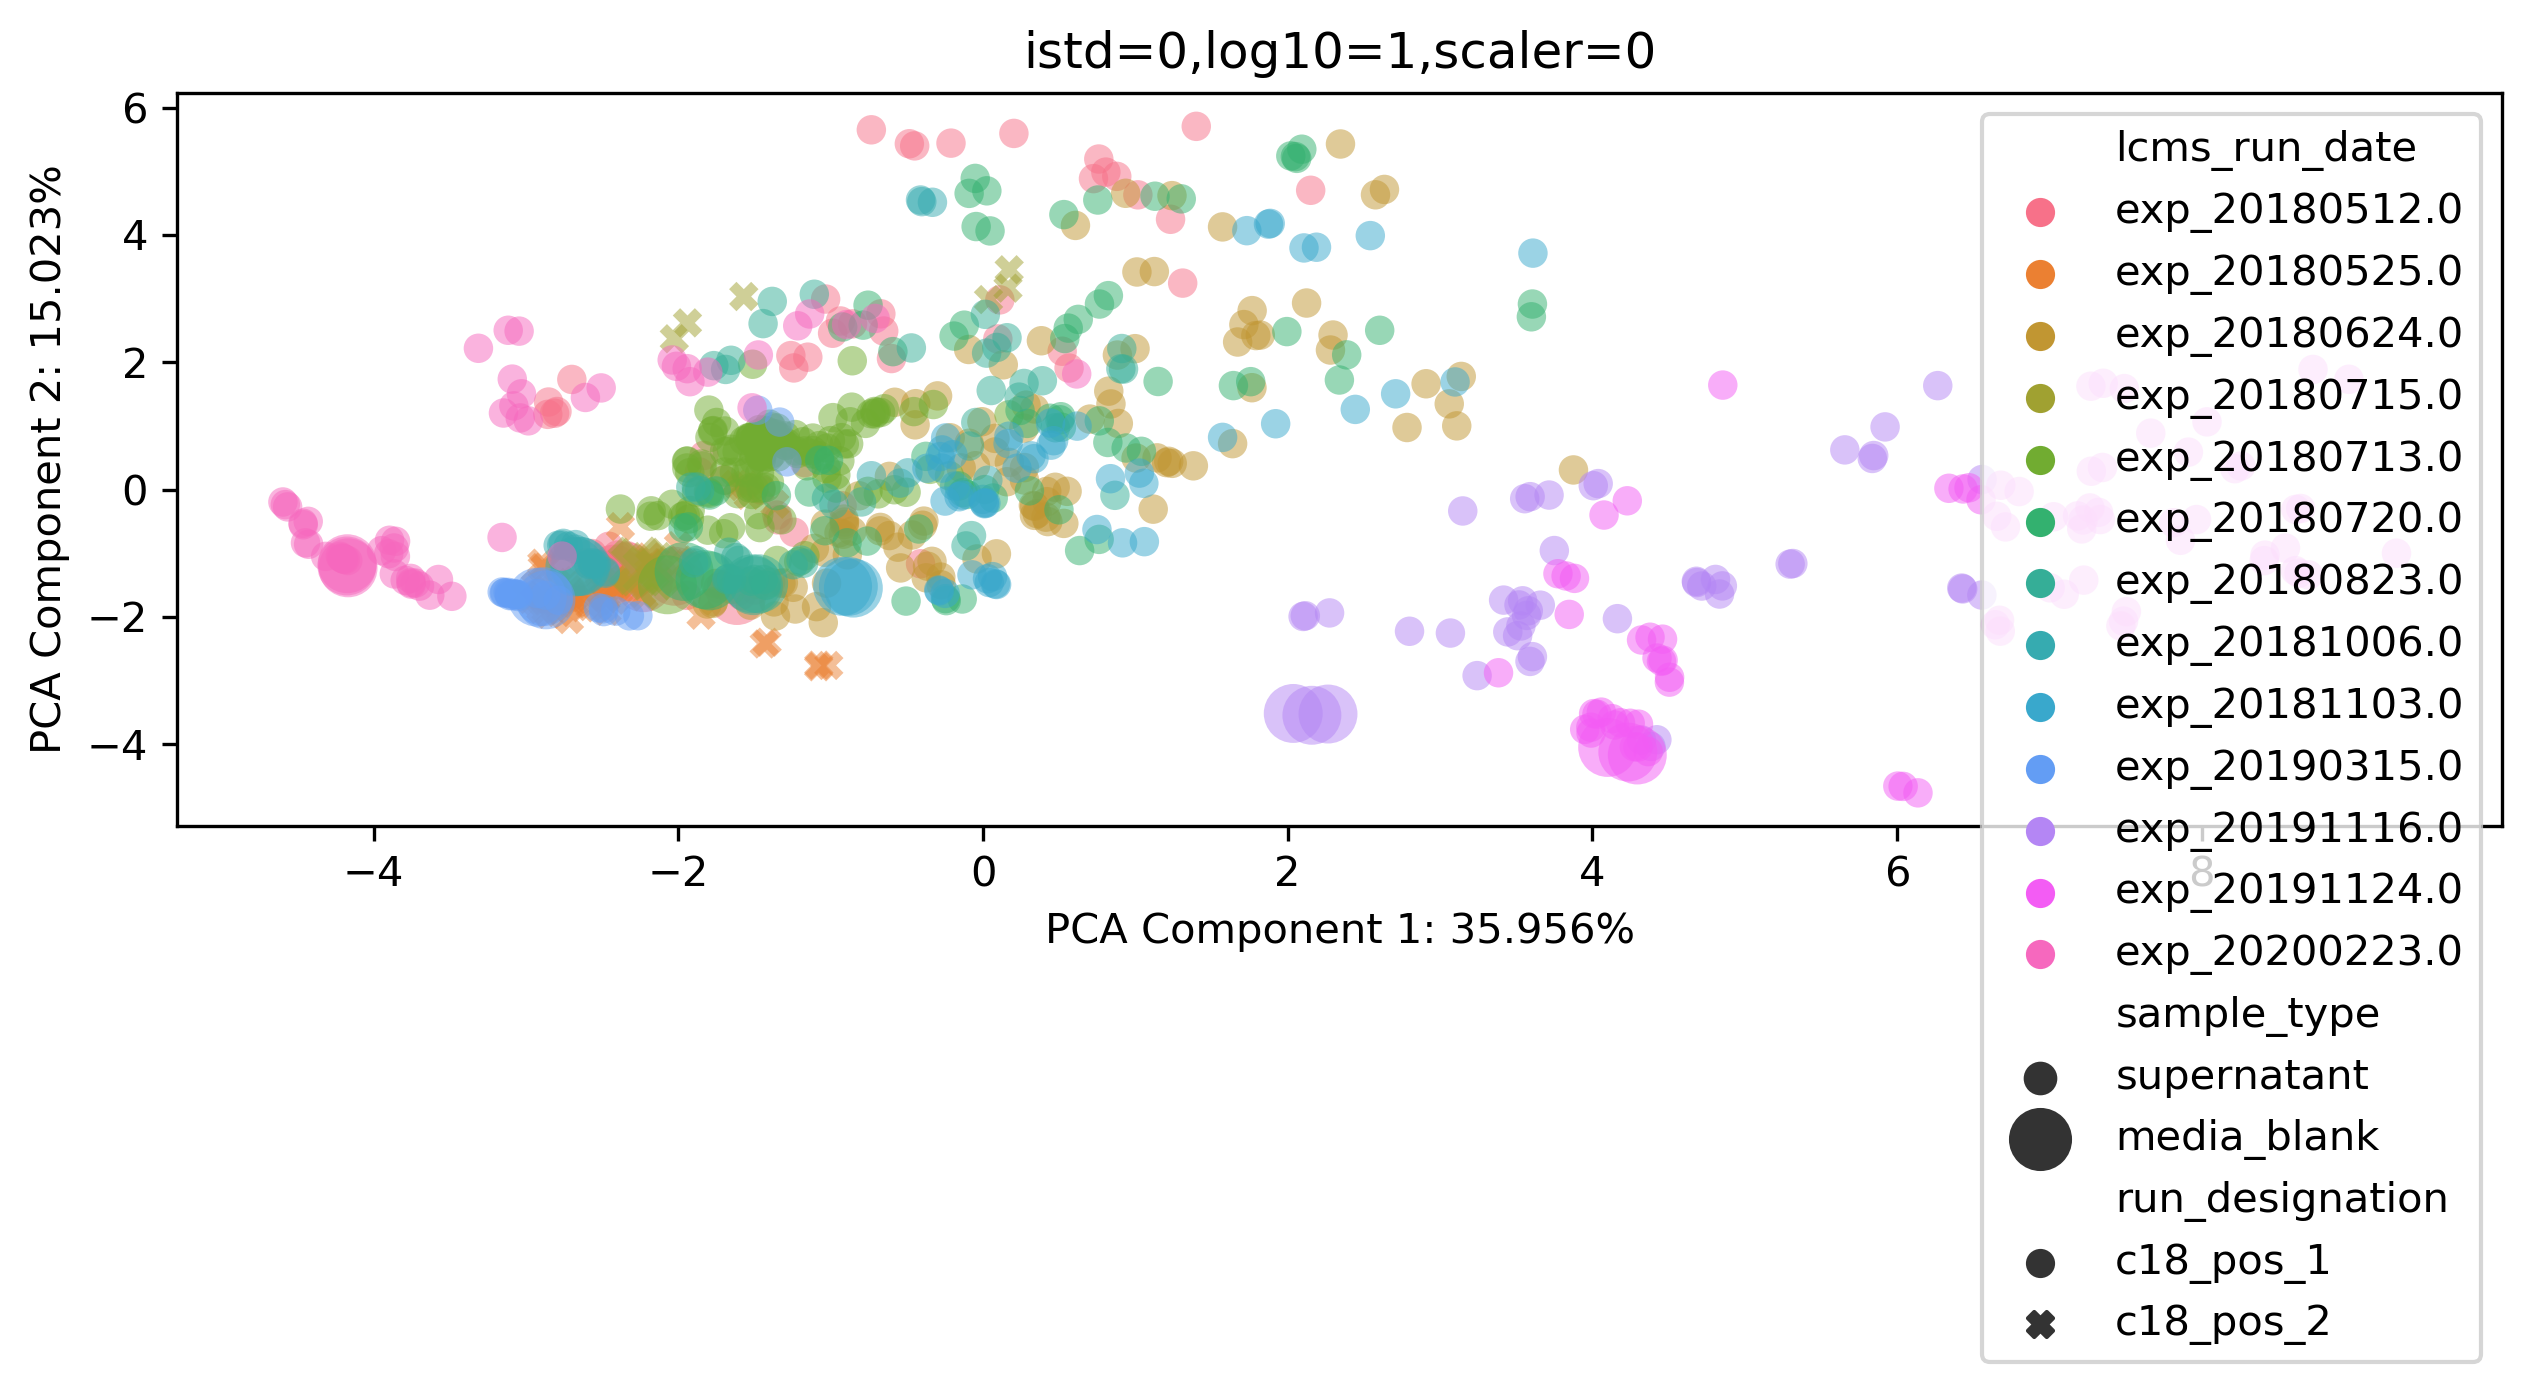

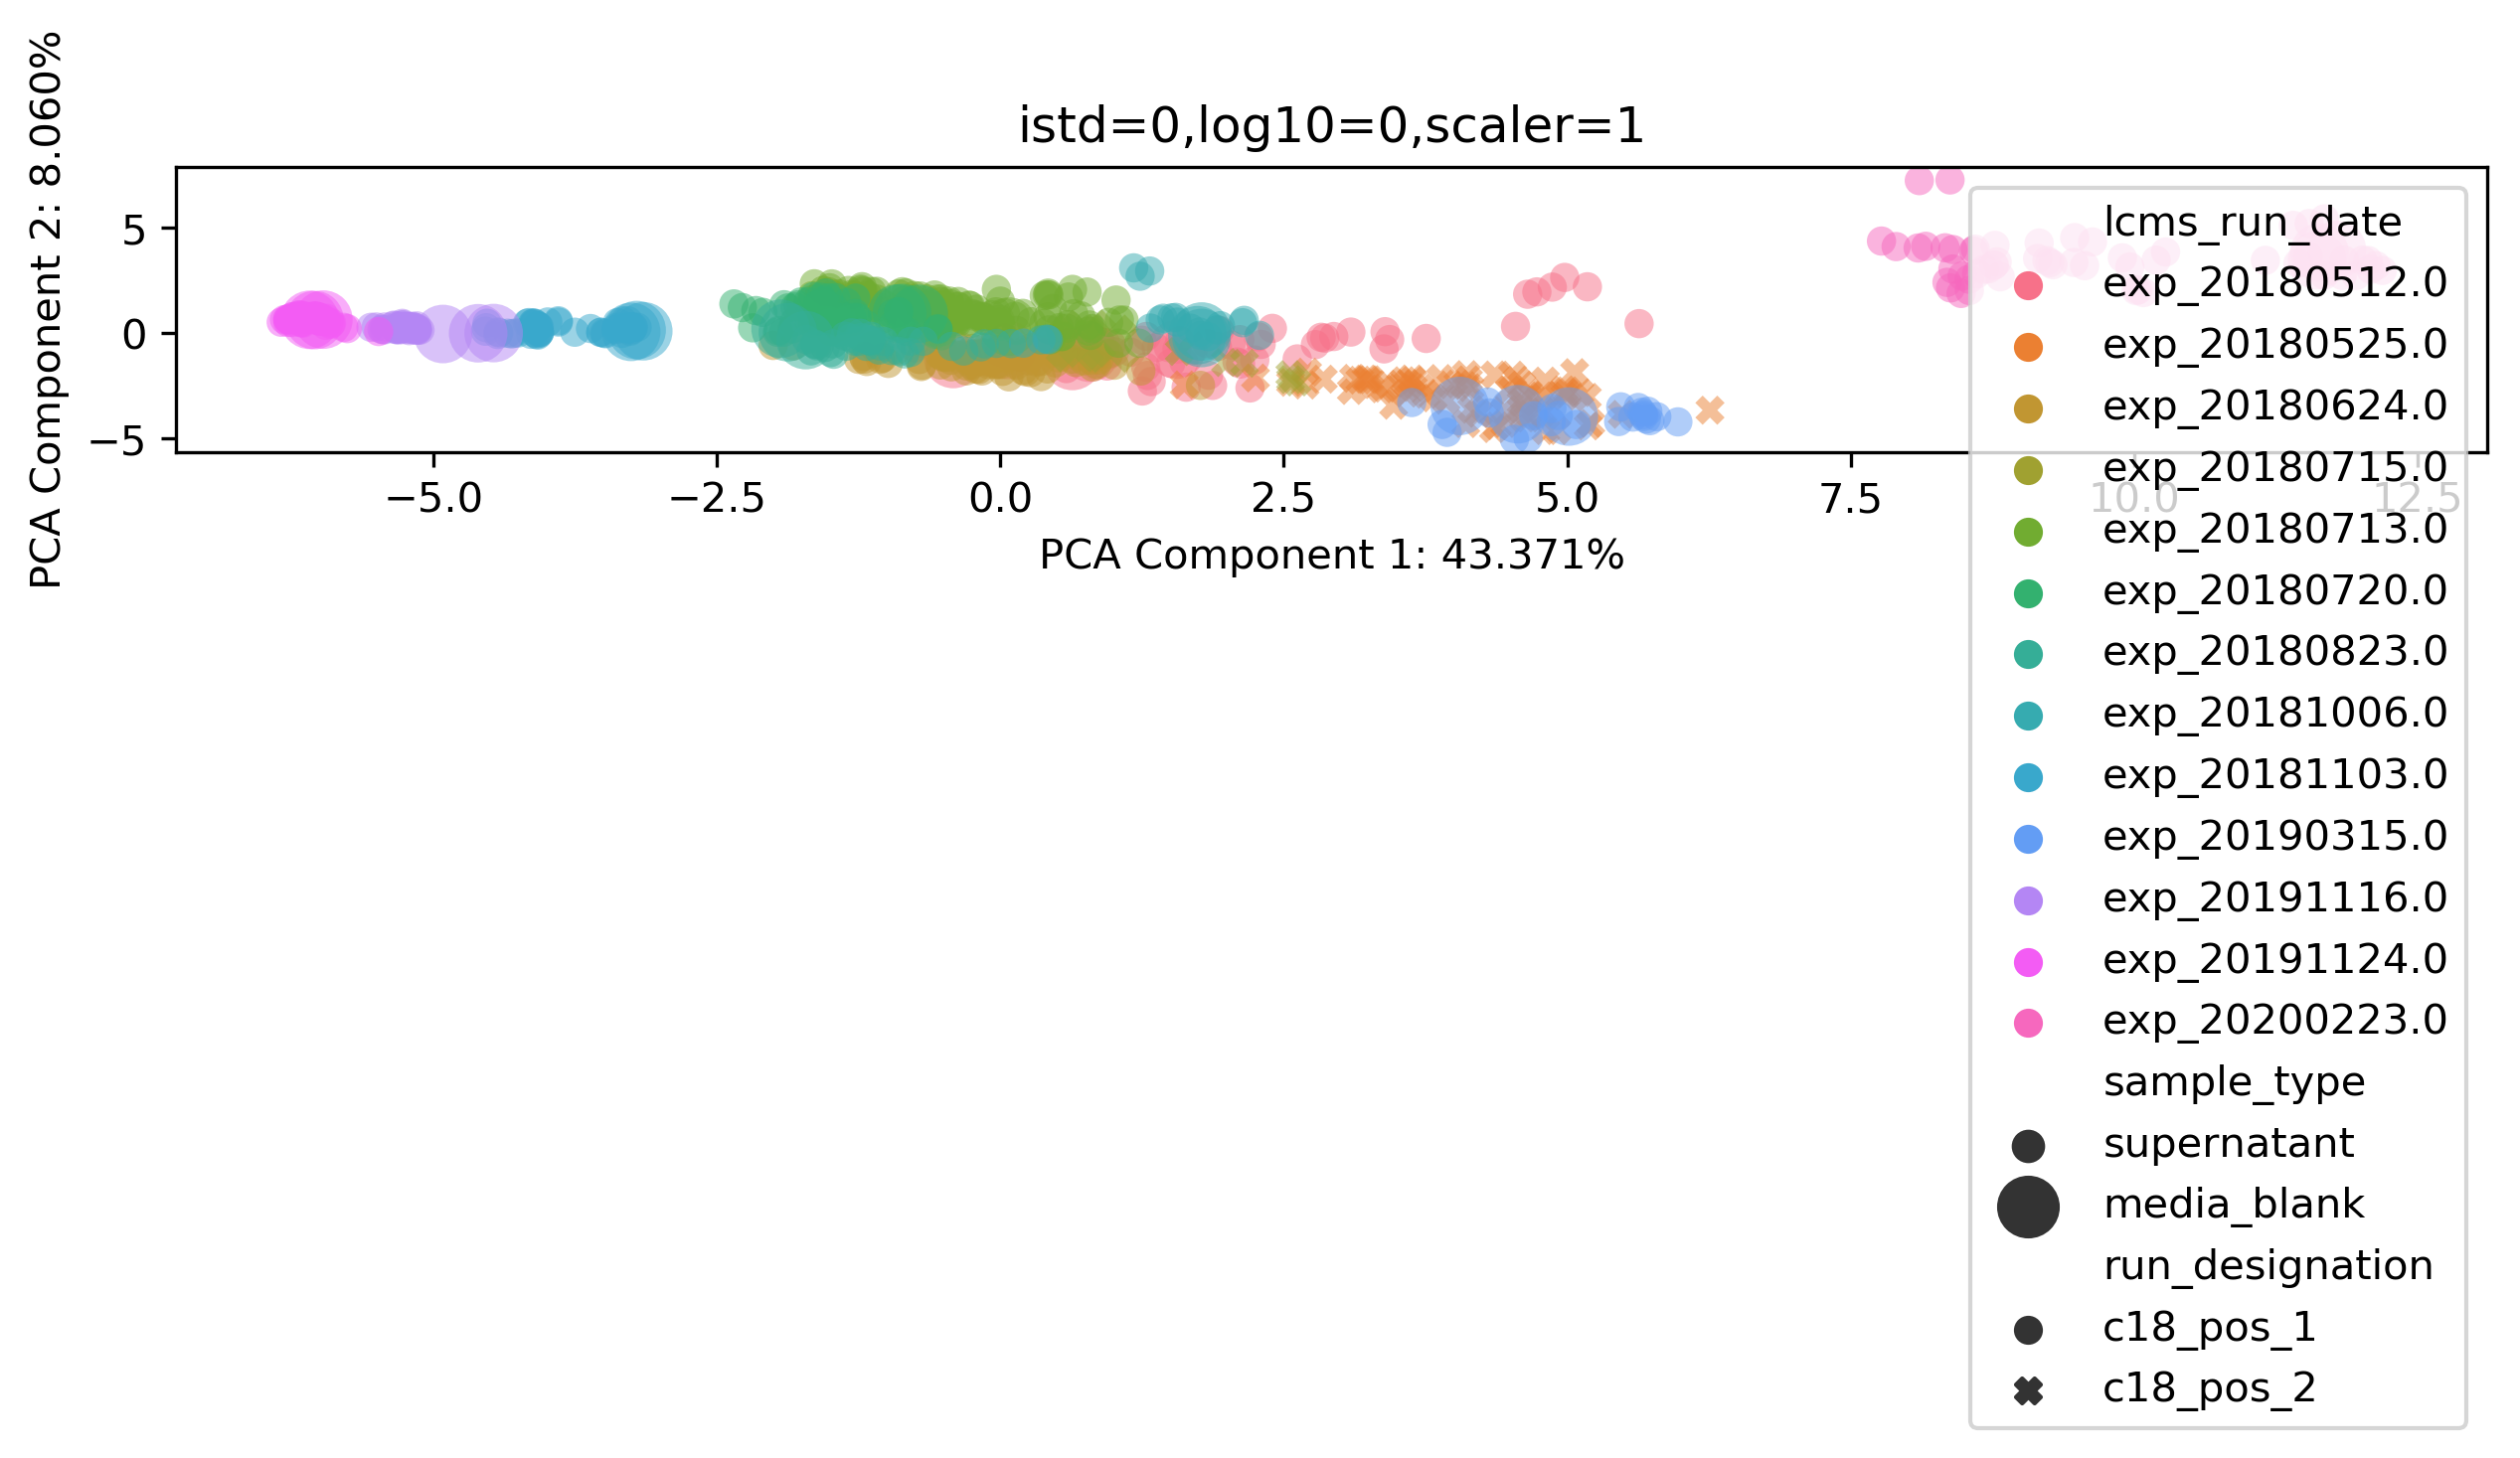

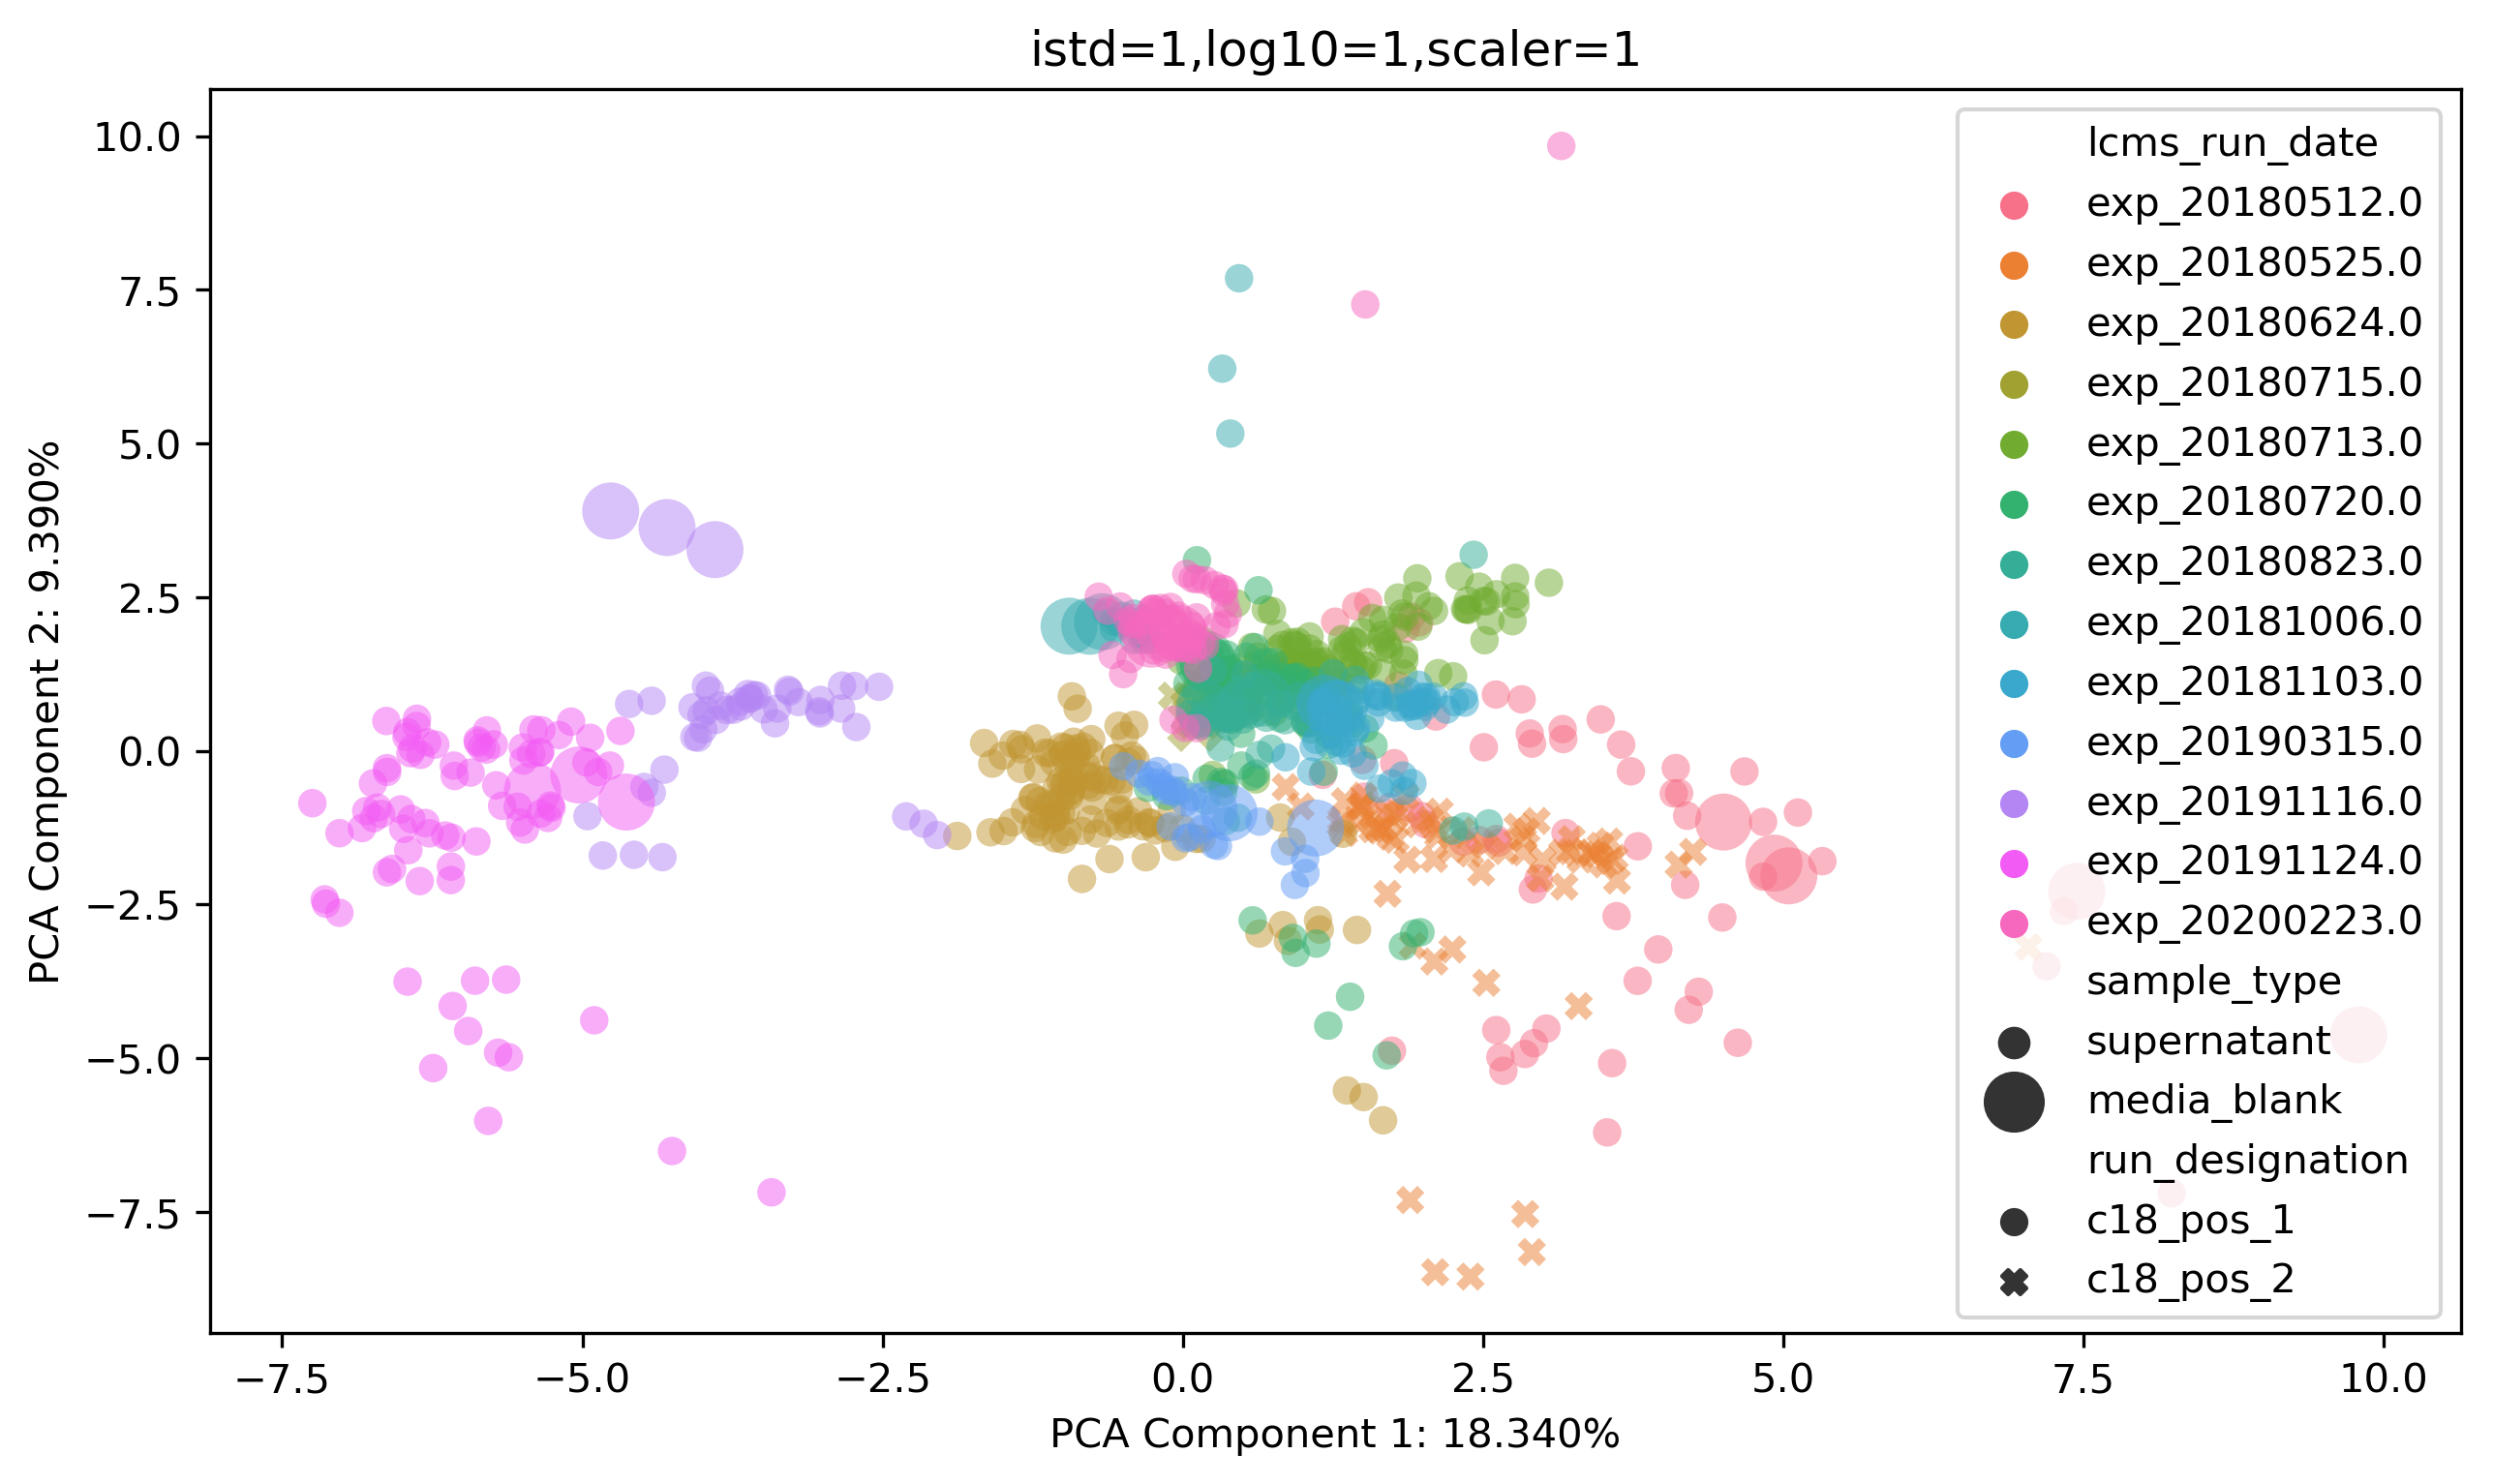

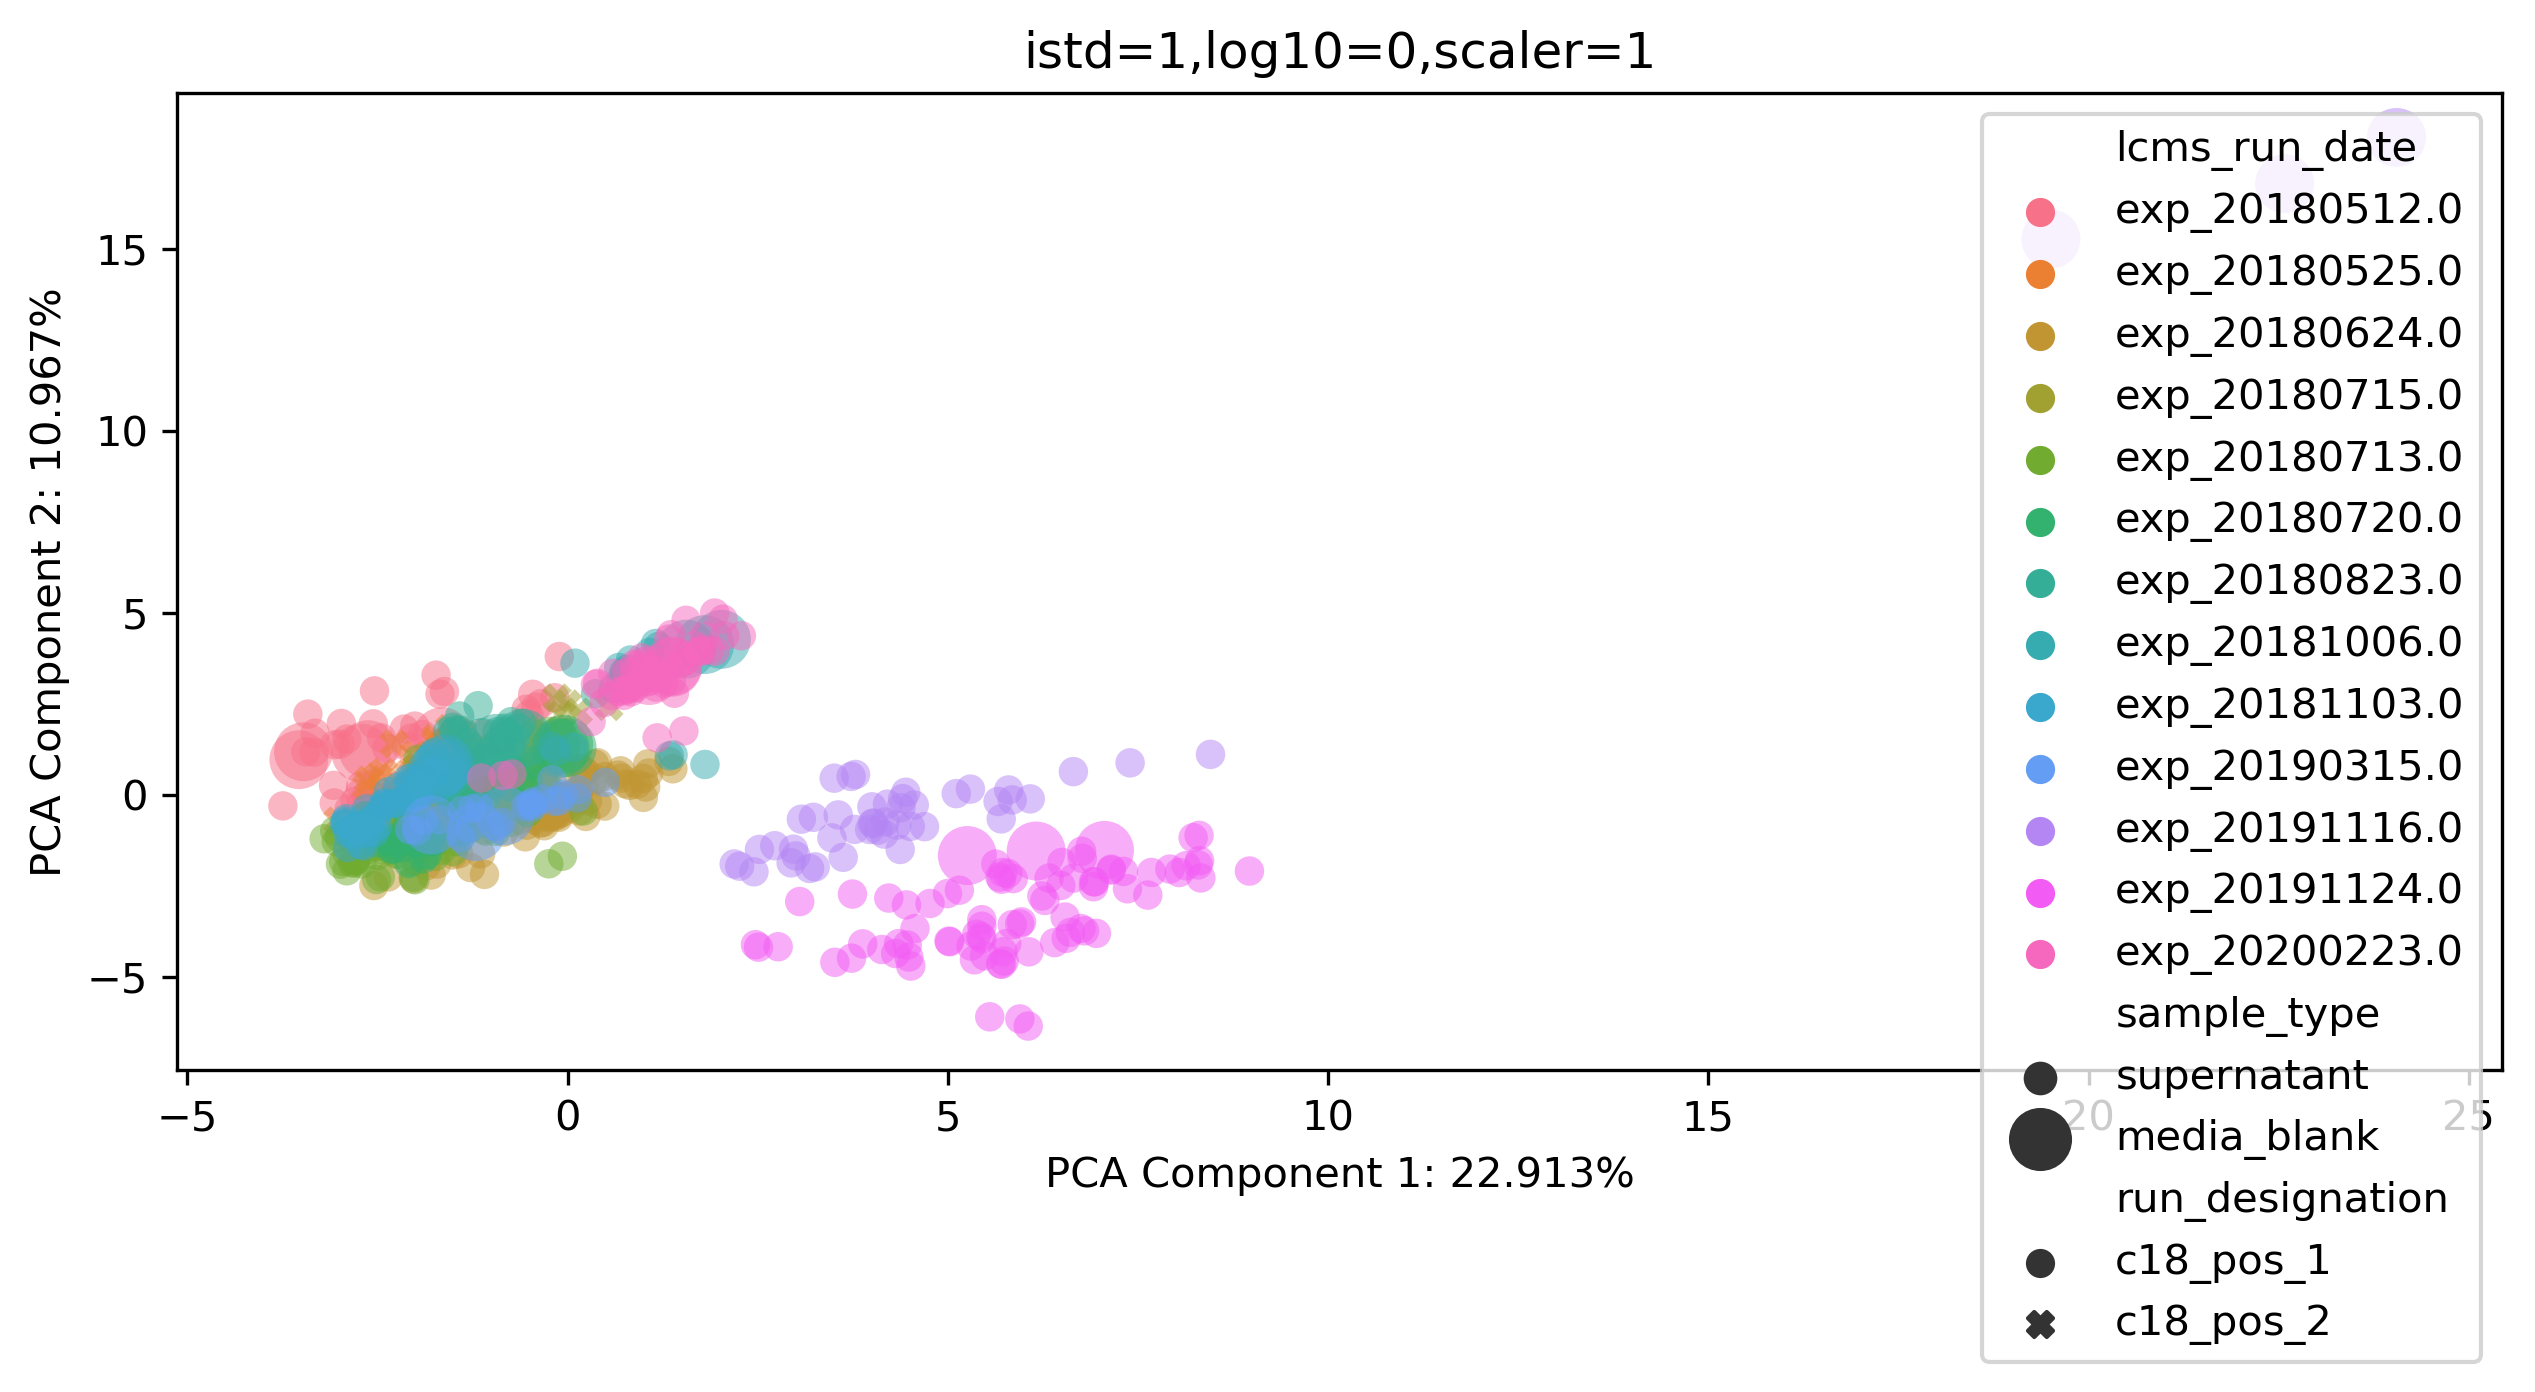

In [18]:
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler

all_istds = np.array(['m_c18n_0553', 'm_c18n_0554', 'm_c18n_0555', 'm_c18n_0556',
       'm_c18n_0557', 'm_c18n_0558', 'm_c18n_0559', 'm_c18n_0560',
       'm_c18n_0561', 'm_c18n_0562', 'm_c18n_0563', 'm_c18n_0564',
       'm_c18n_0565', 'm_c18n_0566', 'm_c18n_0567', 'm_c18p_0556',
       'm_c18p_0564', 'm_c18p_0563', 'm_c18p_0566', 'm_c18p_0568',
       'm_c18p_0571', 'm_c18p_0558', 'm_c18p_0557', 'm_c18p_0562',
       'm_c18p_0565', 'm_c18p_0559', 'm_c18p_0560', 'm_c18p_0561',
       'm_c18p_0555', 'm_c18p_0554', 'm_c18p_0567', 'm_c18p_0569',
       'm_c18p_0570', 'm_hilicp_0357', 'm_hilicp_0358', 'm_hilicp_0359',
       'm_hilicp_0360', 'm_hilicp_0361', 'm_hilicp_0362', 'm_hilicp_0363',
       'm_hilicp_0364', 'm_hilicp_0365', 'm_hilicp_0366', 'm_hilicp_0367',
       'm_hilicp_0368'])

### C18 positive
c18p_exps = {k:v for k, v in exps.items() if 
             (v.chromatography=='c18' and v.ionization=='positive')}
# Remove the 20181108 experiments - they were done in a different way.
c18p_exps.pop((20181108, 'c18_pos_1'))
c18p_exps.pop((20181108, 'c18_pos_2'))

samples = []
for k, exp in c18p_exps.items():
    s = exp.samples['supernatants'].union(exp.samples['unspent_medias'])
    samples.extend(list(s))

# First, we'll examine mega media only, and see if different transformations
# improve the data.
# 1. remove non-mega media samples
# 2. remove columns that are not universally detected, are ISTDS, or are
#    inconsistently detected/bad peaks.
good_samples = md.index[(md['media'] == 'mm') & np.in1d(md.index, samples)]

good_columns = (msdata[0].loc[good_samples, :].notnull().all(0).values)
good_columns = good_columns & ~np.in1d(msdata[0].columns, all_istds)

c18p_raw = msdata[0].loc[good_samples, good_columns]
c18p_istdtic = tic_corr_data[0].loc[good_samples, good_columns]

cols = ['sample_type', 'preculture_date', 'lcms_run_date', 'media',
        'run_designation']
exp_md = md.loc[good_samples, cols]
exp_md['preculture_date'] = list(map(lambda x: 'exp_' + str(x), 
                                     exp_md['preculture_date']))
exp_md['lcms_run_date'] = list(map(lambda x: 'exp_' + str(x), 
                                     exp_md['lcms_run_date']))

# istd, log, scaler
data = {}
data[(0, 0, 0)] = c18p_raw
data[(1, 0, 0)] = c18p_istdtic
data[(0, 1, 0)] = np.log10(1 + c18p_raw)
data[(1, 1, 0)] = np.log10(1 + c18p_istdtic)

scaler = StandardScaler()

data[(0, 0, 1)] = scaler.fit(c18p_raw).transform(c18p_raw)
data[(1, 0, 1)] = scaler.fit(c18p_istdtic).transform(c18p_istdtic)

tmp = np.log10(1 + c18p_raw)
data[(0, 1, 1)] = scaler.fit(tmp).transform(tmp)

tmp = np.log10(1 + c18p_istdtic)
data[(1, 1, 1)] = scaler.fit(tmp).transform(tmp)

for k, v in data.items():
    pca = PCA(n_components=10, random_state=100) # random state stabilizes the output, some variance
    X_r = pca.fit(v).transform(v)
    tmp = exp_md.copy()
    tmp['x1'] = X_r[:, 0]
    tmp['x2'] = X_r[:, 1]

    ex_var_1 = pca.explained_variance_ratio_[0]
    ex_var_2 = pca.explained_variance_ratio_[1]

    # mpl aspect is height to width
    aspect = ex_var_2 / ex_var_1
    fig = plt.figure(figsize=(10, 10), dpi=300)
    ax = fig.add_subplot(111, aspect=aspect)

    sns.scatterplot(ax=ax, x='x1', y='x2', data=tmp, hue='lcms_run_date',
                    style='run_designation', size='sample_type',
                    sizes=(200, 50), linewidth=0, alpha=0.5, legend='full')
    
    ax.set_xlabel('PCA Component 1: {:0.3f}%'.format(100 * ex_var_1))
    ax.set_ylabel('PCA Component 2: {:0.3f}%'.format(100 * ex_var_2))
    ax.set_title('istd=%s,log10=%s,scaler=%s' % k)


### Pipeline Cells
Now we aggregate the data as described in Extended Data Figure 2. In short, we are creating a row X column matrix representing sample X meatbolomic feature regardless of LC-MS mode used to measure that feature. We then average/resolve redundant features as explained in the Supplementary Methods.

In [19]:
###
# 4. Aggregate data
###

# Load the data linking samples across modes.
sample_link = pd.read_excel(io=master_sample_database_fp,
                            sheet_name='sample_link')
# Remove data from sample_link if that data was not run/eliminated.
good_samples = superset([exp.samples['all'] for exp in exps.values()])
for mode in ('c18positive', 'c18negative', 'hilicpositive'):
    idxs = [i not in good_samples for i in sample_link[mode]]
    sample_link.loc[idxs, mode] = np.nan

# Columns to retain in aggregated data
cols = ['experiment', 'sample_type', 'clean_by_16s', 'media', 'culture_source',
        'taxonomy', 'storage_loc_plate', 'storage_loc_well', 'subculture_time',
        'preculture_time']

results_sids = []
results_md = []
for _, row in sample_link.iterrows():
    # cp_sid, cn_sid, hp_sid, repeats = row
    results_sids.append(row[:3].values)
    sids = row[:3][row[:3].notnull()].values
    tmp = md.loc[sids, cols]
    row_data = []
    for col in cols:
        value = squeeze_metadata(tmp[col])
        if value is None:
            print('inconsistent %s in %s' % (col, ','.join(sids)))
        row_data.append(value)
    results_md.append(row_data)

aggregated_md = pd.DataFrame(results_md, columns=cols)
# Add sample IDs
sids = np.vstack(results_sids)
aggregated_md['c18positive'] = sids[:, 0]
aggregated_md['c18negative'] = sids[:, 1]
aggregated_md['hilicpositive'] = sids[:, 2]

# The metadata of all are the same. They contain only data on media blanks and
# supernatant samples because we are subsetting to what's in `aggregated_md`;
# this contains only the things in the `sample_link` database (only
# supernatants and media blanks).
count_raw, _= join_across_modes(aggregated_md, *msdata)

count, _ = join_across_modes(aggregated_md, *tic_corr_data)
delta, _ = join_across_modes(aggregated_md, *delta_data)
fc, agg_md = join_across_modes(aggregated_md, *fc_data)

count_pc, _ = join_across_modes(aggregated_md, *tic_corr_peak_combined_data)
delta_pc, _ = join_across_modes(aggregated_md, *delta_peak_combined_data)
fc_pc, _ = join_across_modes(aggregated_md, *fc_peak_combined_data)

inconsistent storage_loc_plate in s04628,s04668,s04708
inconsistent storage_loc_well in s04628,s04668,s04708
inconsistent storage_loc_plate in s04629,s04669,s04709
inconsistent storage_loc_well in s04629,s04669,s04709
inconsistent storage_loc_plate in s04630,s04670,s04710
inconsistent storage_loc_well in s04630,s04670,s04710


Here, we remove the supernatants that have been identified as biologically artifactual or suspicious. See `sample_qc_classification.ipynb` for the RF implementation that led in part to this list of removals.

In [21]:
###
# 4.1 Remove the samples that we've identified as bad replicates via inspection
#     visually, with random forests, and by diagnostic metabolites.
###
# Note: this is an awful and slow block of code. I am comparing this way in case
# future revisions make the indices of `agg_md` unstable. pd.df.query may
# be a faster way to accomplish this all column check but I am unsure.
# The presence of the sample id's in the last 3 columns ensures that
# only one row will match.
removal_check_cols = ['taxonomy', 'experiment', 'media', 'c18positive',
                      'c18negative', 'hilicpositive']
removal_fp = 'bacterial_supernatant_data/qc/removals.txt'
removal_df = pd.read_csv(removal_fp, sep='\t')
tmp_agg_md = agg_md[removal_check_cols].copy()
tmp_agg_md['experiment'] = tmp_agg_md['experiment'].astype(int)
db_idxs_to_remove = []
for _removal_sid, removal_row in removal_df.iterrows():
    for _db_sid, db_row in tmp_agg_md.iterrows():
        if db_row.equals(removal_row):
            db_idxs_to_remove.append(_db_sid)
            break
# These are the indices to retain. 
good_idxs = ~np.in1d(agg_md.index, db_idxs_to_remove)
# Remove bad indices
agg_md = agg_md.loc[good_idxs, :]
count_raw = count_raw.loc[good_idxs, :]
count = count.loc[good_idxs, :]
delta = delta.loc[good_idxs, :]
fc = fc.loc[good_idxs, :]
count_pc = count_pc.loc[good_idxs, :]
delta_pc = delta_pc.loc[good_idxs, :]
fc_pc = fc_pc.loc[good_idxs, :]

# Prepare to filter fold change data based on count or delta. We must group by
# taxonomy and by culture source.
# Make sure there are no null values in the culture source or taxonomy fields
# for supernatant samples. This would cause them to be skipped in the gb.
assert agg_md.loc[(agg_md['sample_type'] == 'supernatant'),
                  'culture_source'].isnull().sum() == 0
assert agg_md.loc[(agg_md['sample_type'] == 'supernatant'),
                  'taxonomy'].isnull().sum() == 0
# Note: we are excluding media blanks from this filtration calculation. If we
# did not, we'd have to fill the fields `taxonomy` and `culture_source` so that
# the groupby operation would work.
# tmp = agg_md.copy()
# tmp['taxonomy'].fillna('-mb', inplace=True)
# tmp['culture_source'].fillna('-mb', inplace=True)
grouping = ['experiment', 'culture_source', 'taxonomy', 'media']
index_groups = []
for k, g in agg_md.groupby(grouping):
    index_groups.append(g.index.values)

# Mask requiring metabolites to have at least some delta change from the media
# blank or some minimum count (Delta Media Filtered = dmf).
fc_pc_dmf_mask = pd.DataFrame(np.ones(fc_pc.shape), index=fc_pc.index,
                              columns=fc_pc.columns)
# Mask requiring metabolites to have max / min < thresh (for given replicates).
# (Replicate Variation Filtered = rfv)
fc_pc_rvf_mask = pd.DataFrame(np.ones(fc_pc.shape), index=fc_pc.index,
                             columns=fc_pc.columns)

for indices in index_groups:
    bad_cols = ~((np.abs(delta_pc.loc[indices, :].mean(0)) > 3000) | 
                 (count_pc.loc[indices, :].mean(0) > 3000))
    fc_pc_dmf_mask.loc[indices, bad_cols] = np.nan

    tmp = count_pc.loc[indices, :].values.copy()
    _max = np.ma.masked_invalid(tmp).max(0)
    _min = np.ma.masked_invalid(tmp).min(0)
    ratio = _max / _min

    bad_cols_vf = (ratio > 10)

    fc_pc_rvf_mask.loc[indices, bad_cols_vf] = np.nan

fc_pc_dm_filtered = fc_pc * fc_pc_dmf_mask
fc_pc_dmrv_filtered = fc_pc * fc_pc_rvf_mask * fc_pc_dmf_mask


###
# 4.2: combine features that are co-detected between modes.
###

combine_fp = 'bacterial_supernatant_data/qc/feature_combinations.xlsx'
combine = pd.read_excel(combine_fp)

thresh = 3

to_combine = []
new_names = []
for _, row in combine[['features', 'feature_pref', 'pref_strength']].iterrows():
    all_fs, pref_fs, pref_st = row[0].split(','), row[1].split(','), row[2]

    to_combine.append((all_fs, pref_fs, pref_st))
    new_names.append(pref_fs[0]) # Which name doesn't matter - same cpd.

fc_favg = combine_features_in_fc_data(fc, to_combine, new_names,
                                      pref_strength_threshhold=thresh)
fc_pc_favg = combine_features_in_fc_data(fc_pc, to_combine, new_names,
                                         pref_strength_threshhold=thresh)
fc_pc_dmf_favg = combine_features_in_fc_data(fc_pc_dm_filtered, to_combine,
                                             new_names,
                                             pref_strength_threshhold=thresh)
fc_pc_dmrvf_favg = combine_features_in_fc_data(fc_pc_dmrv_filtered, to_combine,
                                               new_names,
                                               pref_strength_threshhold=thresh)

# Convince ourselves the transformation has worked correctly.
pref_features = []
for i in combine['feature_pref']:
    pref_features.extend(i.split(','))

dropped_features = []
for i in combine['features']:
    dropped_features.extend(i.split(','))

unchanged = set(fc.columns) - set(pref_features).union(dropped_features)
assert fc.loc[:, unchanged].equals(fc_favg.loc[:, unchanged])

fs = 'm_c18n_0275,m_c18p_0272'.split(',')
tmp = fc[fs]
idxs = tmp.iloc[:, 1].isnull()
assert (fc.loc[~idxs, 'm_c18p_0272'] == fc_favg.loc[~idxs, 'm_c18p_0272']).all()
assert fc.loc[idxs, fs].mean(1).equals(fc_favg.loc[idxs, 'm_c18p_0272'])


## Write the data out as several different types
base_fp = 'bacterial_supernatant_data/current_aggregation_pipeline_output/'

# Raw counts
count_raw.to_csv(base_fp + 'count.raw.txt', sep='\t')

# ISTD corrected raw counts
count.to_csv(base_fp + 'count.txt', sep='\t')
count_pc.to_csv(base_fp + 'count.ps.txt', sep='\t')

# Deltas
delta.to_csv(base_fp + 'delta.txt', sep='\t')
delta_pc.to_csv(base_fp + 'delta.ps.txt', sep='\t')

# Fold changes
fc.to_csv(base_fp + 'foldchange.txt', sep='\t')
fc_favg.to_csv(base_fp + 'foldchange.fa.txt', sep='\t')
fc_pc_favg.to_csv(base_fp + 'foldchange.fa.ps.txt',
                  sep='\t')
fc_pc_dmf_favg.to_csv(base_fp + 'foldchange.dmf.fa.ps.txt',
                           sep='\t')
fc_pc_dmrvf_favg.to_csv(base_fp + 'foldchange.dmrvf.fa.ps.txt',
                        sep='\t')
np.log2(fc_pc_dmrvf_favg).to_csv(base_fp + 'foldchange.dmrvf.fa.ps.log2.txt',
                                 sep='\t')


# The experimental objects.
pickle.dump(exps, open(base_fp + 'experiment_objects.pickle', 'wb'))
pickle.dump(bsgs, open(base_fp + 'bsg_objects.pickle', 'wb'))


## Add taxonomic information to the aggregated metadata
sac_fp = 'supplemental_table_6.xlsx'
# Culture and sequence metadata
sac = pd.read_excel(sac_fp, index_col=0, sheet_name='cultures')
taxonomies = pd.read_excel(sac_fp, index_col=0, sheet_name='full_taxonomy')
# Join taxonomy data with sac to link culture to taxonomic rank information
tmp = ['taxonomy', 'clean_by_16s', '16s_feature', 'kingdom', 'phylum', 'class',
       'order', 'family', 'genus', 'species', 'strain', 'morphology',
       'supplier', 'number']
strain_metadata = sac.join(taxonomies, on='taxonomy')[tmp]

agg_md_w_taxonomy = agg_md.copy()

tlevels = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species',
           'strain', 'morphology']
for lvl in tlevels:
    agg_md_w_taxonomy[lvl] = ''

for idx, row in agg_md.iterrows():
    if row['sample_type'] == 'supernatant':
        agg_md_w_taxonomy.loc[idx, tlevels] = \
            strain_metadata.loc[row['culture_source'], tlevels].values

agg_md_w_taxonomy['grouped_taxonomy'] = \
    agg_md_w_taxonomy[['genus', 'species']].fillna('').apply(
        lambda x: ' '.join(x).strip(), axis=1)

order = ['experiment', 'sample_type', 'media', 'subculture_time',
         'preculture_time', 'c18positive', 'c18negative', 'hilicpositive',
         'culture_source', 'taxonomy', 'grouped_taxonomy', 'kingdom', 'phylum',
         'class', 'order','family', 'genus', 'species', 'strain', 'morphology']

agg_md_with_taxonomy_fp = 'aggregated_md.txt'

agg_md_w_taxonomy[order].to_csv(agg_md_with_taxonomy_fp, sep='\t')

Feature `m_c18n_0039` not detected.
Feature `m_hilicp_0085` not detected.
Feature `m_c18p_0081` not detected.
Preferred feature `m_c18p_0081` not detected.

Feature `m_c18n_0140` not detected.
Preferred feature `m_c18n_0140` not detected.

Feature `m_c18n_0166` not detected.
Preferred feature `m_c18n_0166` not detected.

Feature `m_c18n_0238,m_c18p_0234` not detected.
Preferred feature `m_c18n_0238,m_c18p_0234` not detected.

Feature `m_hilicp_0235` not detected.
Feature `m_hilicp_0123` not detected.
Preferred feature `m_hilicp_0123` not detected.

Feature `m_c18n_0039` not detected.
Feature `m_hilicp_0085` not detected.
Feature `m_c18p_0081` not detected.
Preferred feature `m_c18p_0081` not detected.

Feature `m_c18n_0140` not detected.
Preferred feature `m_c18n_0140` not detected.

Feature `m_c18n_0166` not detected.
Preferred feature `m_c18n_0166` not detected.

Feature `m_c18n_0238,m_c18p_0234` not detected.
Preferred feature `m_c18n_0238,m_c18p_0234` not detected.

Feature `m_hili

KeyError: 'the label [c0170] is not in the [index]'